<a href="https://colab.research.google.com/github/wolfinwallst/Machine_Learning_Deep_basis/blob/main/ongoing_RL_PPO_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  20 of 20 completed


PPO Episode 0 | Reward: 2.1404 | Critic Loss: 0.0040
PPO Episode 1 | Reward: 2.1380 | Critic Loss: 0.0037
PPO Episode 2 | Reward: 2.1361 | Critic Loss: 0.0037
PPO Episode 3 | Reward: 2.1349 | Critic Loss: 0.0036
PPO Episode 4 | Reward: 2.1338 | Critic Loss: 0.0035
PPO Episode 5 | Reward: 2.1330 | Critic Loss: 0.0035
PPO Episode 6 | Reward: 2.1330 | Critic Loss: 0.0035
PPO Episode 7 | Reward: 2.1336 | Critic Loss: 0.0035
PPO Episode 8 | Reward: 2.1348 | Critic Loss: 0.0034
PPO Episode 9 | Reward: 2.1356 | Critic Loss: 0.0034
PPO Episode 10 | Reward: 2.1362 | Critic Loss: 0.0034
PPO Episode 11 | Reward: 2.1371 | Critic Loss: 0.0034
PPO Episode 12 | Reward: 2.1378 | Critic Loss: 0.0034
PPO Episode 13 | Reward: 2.1384 | Critic Loss: 0.0034
PPO Episode 14 | Reward: 2.1389 | Critic Loss: 0.0034
PPO Episode 15 | Reward: 2.1391 | Critic Loss: 0.0034
PPO Episode 16 | Reward: 2.1395 | Critic Loss: 0.0034
PPO Episode 17 | Reward: 2.1401 | Critic Loss: 0.0034
PPO Episode 18 | Reward: 2.1405 | Crit

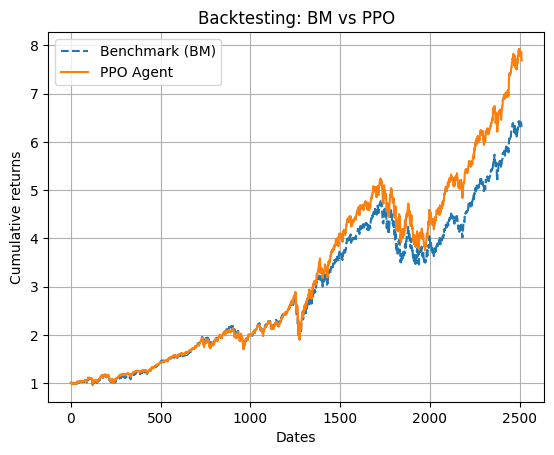

In [ ]:
# PPO 포트 최적화
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정)"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)  # 확률 분포 변환

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        action = self.softmax(logits)  # 확률값 반환
        return action

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

    """
    actor.train() # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    # 전체 학습 과정 시작 (num_episodes 만큼 반복)
    for episode in range(num_episodes):
        states, actions, rewards, old_probs = [], [], [], []
        state = env.reset() # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False # 에피소드 종료 여부

        # (3) 하나의 에피소드 동안 반복 (환경이 종료될 때까지)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            # Actor 네트워크를 통해 행동(action) 예측 (포트폴리오 가중치)
            action = actor(state_tensor).squeeze(0)
            # 상태, 행동, 행동 확률(old_probs)을 저장 (나중에 업데이트에 활용)
            states.append(state)
            actions.append(action.detach().numpy())
            old_probs.append(action.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        returns = []
        R = 0 # 미래 보상의 누적 값
        for r in reversed(rewards):  # 보상을 역순으로 반복
            R = r + gamma * R
            returns.insert(0, R)  # 앞쪽에 삽입하여 정방향 순서로 저장
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        old_probs_tensor = torch.stack(old_probs)

        # (6) PPO 업데이트 (K_epochs 만큼 반복)
        for _ in range(K_epochs):
            # Critic 네트워크를 이용하여 현재 상태의 가치 예측
            values = critic(states_tensor).squeeze(1)  # [batch_size] 형태로 변환
            advantages = returns - values.detach() # 실제 리턴(returns) - 예측 가치(values)
            # Advantage를 정규화하여 안정적인 학습 유도
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Actor 네트워크에서 새로운 행동 확률 계산
            new_probs = actor(states_tensor)
            # PPO 손실 함수 계산
            # (7) 비율 계산: 새로운 정책의 행동 확률 / 기존 정책의 행동 확률
            ratio = (new_probs / old_probs_tensor).prod(dim=1) # .prod(dim=1)는 배열의 요소를 특정 차원(dim=1)을 따라 곱하는 연산으로 각 종목에 대한 개별 행동 확률 비율을 모두 곱해서 최종적인 행동 확률 비율을 만든다는 의미
            # (8) PPO 손실의 두 가지 항목 계산: clamp로 clipping 적용
            surr1 = ratio * advantages  # 기존 방식의 정책 개선 (Unclipped)
            surr2 = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages  # 클리핑 적용된 정책 개선 (Clipped)
            actor_loss = -torch.min(surr1, surr2).mean() # (9) PPO Actor 손실: 두 개의 손실 중 작은 값 선택 (Conservative Update)

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad() # (11) Actor 네트워크 업데이트
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad() # (12) Critic 네트워크 업데이트
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {sum(rewards):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = actor_model(state_tensor).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

plt.plot(benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

PPO Episode 0 | Reward: 2.1492 | Critic Loss: 0.0041
PPO Episode 1 | Reward: 2.1507 | Critic Loss: 0.0038
PPO Episode 2 | Reward: 2.1521 | Critic Loss: 0.0037
PPO Episode 3 | Reward: 2.1532 | Critic Loss: 0.0036
PPO Episode 4 | Reward: 2.1542 | Critic Loss: 0.0036
PPO Episode 5 | Reward: 2.1550 | Critic Loss: 0.0036
PPO Episode 6 | Reward: 2.1560 | Critic Loss: 0.0036
PPO Episode 7 | Reward: 2.1573 | Critic Loss: 0.0036
PPO Episode 8 | Reward: 2.1587 | Critic Loss: 0.0035
PPO Episode 9 | Reward: 2.1601 | Critic Loss: 0.0035
PPO Episode 10 | Reward: 2.1614 | Critic Loss: 0.0035
PPO Episode 11 | Reward: 2.1626 | Critic Loss: 0.0035
PPO Episode 12 | Reward: 2.1636 | Critic Loss: 0.0035
PPO Episode 13 | Reward: 2.1644 | Critic Loss: 0.0034
PPO Episode 14 | Reward: 2.1651 | Critic Loss: 0.0034
PPO Episode 15 | Reward: 2.1659 | Critic Loss: 0.0034
PPO Episode 16 | Reward: 2.1670 | Critic Loss: 0.0034
PPO Episode 17 | Reward: 2.1676 | Critic Loss: 0.0034
PPO Episode 18 | Reward: 2.1684 | Crit

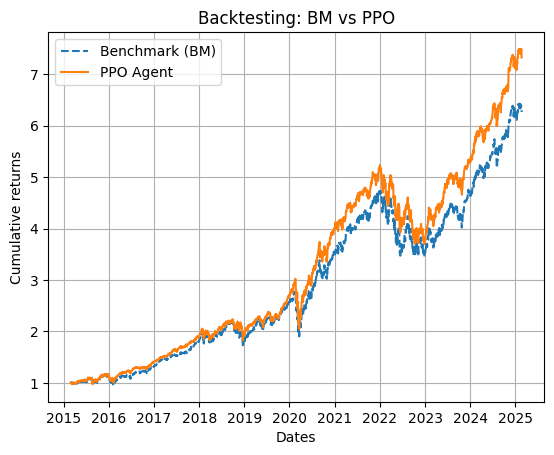

In [ ]:
# 위 코드에서 plotting할 때, 날짜 카운트가 아닌 연도별로 표시되도록 바꿨다.
# (맨 밑에 plt 부분만 수정함)
# PPO 포트 최적화
"""
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()
"""

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정)"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)  # 확률 분포 변환

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        action = self.softmax(logits)  # 확률값 반환
        return action

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

    """
    actor.train() # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    # 전체 학습 과정 시작 (num_episodes 만큼 반복)
    for episode in range(num_episodes):
        states, actions, rewards, old_probs = [], [], [], []
        state = env.reset() # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False # 에피소드 종료 여부

        # (3) 하나의 에피소드 동안 반복 (환경이 종료될 때까지)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            # Actor 네트워크를 통해 행동(action) 예측 (포트폴리오 가중치)
            action = actor(state_tensor).squeeze(0)
            # 상태, 행동, 행동 확률(old_probs)을 저장 (나중에 업데이트에 활용)
            states.append(state)
            actions.append(action.detach().numpy())
            old_probs.append(action.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        returns = []
        R = 0 # 미래 보상의 누적 값
        for r in reversed(rewards):  # 보상을 역순으로 반복
            R = r + gamma * R
            returns.insert(0, R)  # 앞쪽에 삽입하여 정방향 순서로 저장
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        old_probs_tensor = torch.stack(old_probs)

        # (6) PPO 업데이트 (K_epochs 만큼 반복)
        for _ in range(K_epochs):
            # Critic 네트워크를 이용하여 현재 상태의 가치 예측
            values = critic(states_tensor).squeeze(1)  # [batch_size] 형태로 변환
            advantages = returns - values.detach() # 실제 리턴(returns) - 예측 가치(values)
            # Advantage를 정규화하여 안정적인 학습 유도
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Actor 네트워크에서 새로운 행동 확률 계산
            new_probs = actor(states_tensor)
            # PPO 손실 함수 계산
            # (7) 비율 계산: 새로운 정책의 행동 확률 / 기존 정책의 행동 확률
            ratio = (new_probs / old_probs_tensor).prod(dim=1) # .prod(dim=1)는 배열의 요소를 특정 차원(dim=1)을 따라 곱하는 연산으로 각 종목에 대한 개별 행동 확률 비율을 모두 곱해서 최종적인 행동 확률 비율을 만든다는 의미
            # (8) PPO 손실의 두 가지 항목 계산: clamp로 clipping 적용
            surr1 = ratio * advantages  # 기존 방식의 정책 개선 (Unclipped)
            surr2 = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages  # 클리핑 적용된 정책 개선 (Clipped)
            actor_loss = -torch.min(surr1, surr2).mean() # (9) PPO Actor 손실: 두 개의 손실 중 작은 값 선택 (Conservative Update)

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad() # (11) Actor 네트워크 업데이트
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad() # (12) Critic 네트워크 업데이트
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {sum(rewards):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = actor_model(state_tensor).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]

plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

PPO Episode 0 | Reward: 2.1627 | Critic Loss: 0.0045
PPO Episode 1 | Reward: 2.1629 | Critic Loss: 0.0038
PPO Episode 2 | Reward: 2.1630 | Critic Loss: 0.0037
PPO Episode 3 | Reward: 2.1632 | Critic Loss: 0.0037
PPO Episode 4 | Reward: 2.1633 | Critic Loss: 0.0037
PPO Episode 5 | Reward: 2.1630 | Critic Loss: 0.0036
PPO Episode 6 | Reward: 2.1635 | Critic Loss: 0.0036
PPO Episode 7 | Reward: 2.1640 | Critic Loss: 0.0036
PPO Episode 8 | Reward: 2.1640 | Critic Loss: 0.0035
PPO Episode 9 | Reward: 2.1637 | Critic Loss: 0.0035
PPO Episode 10 | Reward: 2.1637 | Critic Loss: 0.0035
PPO Episode 11 | Reward: 2.1638 | Critic Loss: 0.0035
PPO Episode 12 | Reward: 2.1640 | Critic Loss: 0.0034
PPO Episode 13 | Reward: 2.1641 | Critic Loss: 0.0034
PPO Episode 14 | Reward: 2.1640 | Critic Loss: 0.0034
PPO Episode 15 | Reward: 2.1641 | Critic Loss: 0.0034
PPO Episode 16 | Reward: 2.1644 | Critic Loss: 0.0034
PPO Episode 17 | Reward: 2.1645 | Critic Loss: 0.0034
PPO Episode 18 | Reward: 2.1647 | Crit

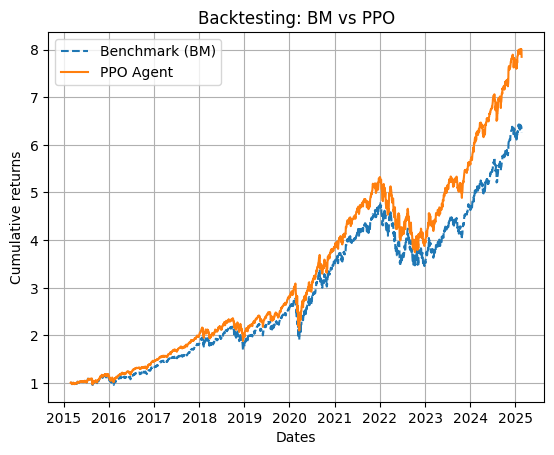

In [ ]:
# 위 코드에서 plotting할 때, 날짜 카운트가 아닌 연도별로 표시되도록 바꿨다.
# (맨 밑에 plt 부분만 수정함)
# PPO 포트 최적화
"""
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()
"""

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정)"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)  # 확률 분포 변환

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        action = self.softmax(logits)  # 확률값 반환
        return action

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)

    """
    actor.train() # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    # 전체 학습 과정 시작 (num_episodes 만큼 반복)
    for episode in range(num_episodes):
        states, actions, rewards, old_probs = [], [], [], []
        state = env.reset() # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False # 에피소드 종료 여부

        # (3) 하나의 에피소드 동안 반복 (환경이 종료될 때까지)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            # Actor 네트워크를 통해 행동(action) 예측 (포트폴리오 가중치)
            action = actor(state_tensor).squeeze(0)
            # 상태, 행동, 행동 확률(old_probs)을 저장 (나중에 업데이트에 활용)
            states.append(state)
            actions.append(action.detach().numpy())
            old_probs.append(action.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        returns = []
        R = 0 # 미래 보상의 누적 값
        for r in reversed(rewards):  # 보상을 역순으로 반복
            R = r + gamma * R
            returns.insert(0, R)  # 앞쪽에 삽입하여 정방향 순서로 저장
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        old_probs_tensor = torch.stack(old_probs)

        # (6) PPO 업데이트 (K_epochs 만큼 반복)
        for _ in range(K_epochs):
            # Critic 네트워크를 이용하여 현재 상태의 가치 예측
            values = critic(states_tensor).squeeze(1)  # [batch_size] 형태로 변환
            advantages = returns - values.detach() # 실제 리턴(returns) - 예측 가치(values)
            # Advantage를 정규화하여 안정적인 학습 유도
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Actor 네트워크에서 새로운 행동 확률 계산
            new_probs = actor(states_tensor)
            # PPO 손실 함수 계산
            # (7) 비율 계산: 새로운 정책의 행동 확률 / 기존 정책의 행동 확률
            ratio = (new_probs / old_probs_tensor).prod(dim=1) # .prod(dim=1)는 배열의 요소를 특정 차원(dim=1)을 따라 곱하는 연산으로 각 종목에 대한 개별 행동 확률 비율을 모두 곱해서 최종적인 행동 확률 비율을 만든다는 의미
            # (8) PPO 손실의 두 가지 항목 계산: clamp로 clipping 적용
            surr1 = ratio * advantages  # 기존 방식의 정책 개선 (Unclipped)
            surr2 = torch.clamp(ratio, 1-epsilon, 1+epsilon) * advantages  # 클리핑 적용된 정책 개선 (Clipped)
            actor_loss = -torch.min(surr1, surr2).mean() # (9) PPO Actor 손실: 두 개의 손실 중 작은 값 선택 (Conservative Update)

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad() # (11) Actor 네트워크 업데이트
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad() # (12) Critic 네트워크 업데이트
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {sum(rewards):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = actor_model(state_tensor).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]

plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

In [ ]:
"""
일단 다른 거 할게 있어서
파인 튜닝은 조금 미뤄두자
"""

In [ ]:
# 위 코드에서 Softmax 대신 Dirichlet 분포 사용”, “로그 확률로 ratio 계산”,
# “정책 손실에 엔트로피 항 추가했다.
# PPO 포트 최적화
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Softmax 대신 Dirichlet 분포 사용
class Actor(nn.Module):
    """PPO 정책 신경망 (행동 결정) - Dirichlet 분포 기반"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()  # alpha 값이 양수가 되도록

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Dirichlet 분포의 파라미터(alpha > 0)를 위해 softplus 적용 후 작은 상수 추가
        alpha = self.softplus(self.fc3(x)) + 1e-6
        dist = torch.distributions.Dirichlet(alpha)
        return dist

class Critic(nn.Module):
    """PPO 가치 신경망 (상태 가치 예측)"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)  # 상태 가치 출력
        return value

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
entropy_coef = 0.01   # [수정됨] 엔트로피 보너스 계수

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
    """
    actor.train()  # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []  # [수정됨] 기존 행동의 로그 확률 저장 리스트
        state = env.reset()  # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False

        # 에피소드 진행 (Trajectory 수집)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist = actor(state_tensor)           # [수정됨] Dirichlet 분포 객체 반환
            action = dist.sample()               # [수정됨] 분포에서 샘플링
            log_prob = dist.log_prob(action)     # [수정됨] 로그 확률 계산

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        # 할인 누적 보상(Return) 계산
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        # 텐서 변환
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        # PPO 업데이트 (K_epochs 반복)
        for _ in range(K_epochs):
            values = critic(states_tensor).squeeze(1)  # Critic 예측
            advantages = returns - values.detach()
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            dist = actor(states_tensor)  # 새로운 분포 계산
            new_log_probs = dist.log_prob(actions_tensor)
            # [수정됨] 로그 확률 차이를 이용한 ratio 계산
            ratio = (new_log_probs - old_log_probs_tensor).exp()

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages

            # [수정됨] 엔트로피 보너스 추가 (탐색 유도)
            entropy = dist.entropy().mean()

            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        # print(f"PPO Episode {episode} | Reward: {sum(rewards):.4f} | Critic Loss: {critic_loss.item():.4f}")
        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # [수정됨] 평가 시에는 Dirichlet 분포의 평균(알파/합) 사용하여 결정론적 행동 선택
            dist = actor_model(state_tensor)
            action = (dist.concentration / dist.concentration.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot (연도별 표시)
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]
# 연도별로 X축 레이블을 표시하도록 설정
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

[*********************100%***********************]  20 of 20 completed
<ipython-input-3-7713331010a0>:197: UserWarning: Using a target size (torch.Size([2511, 1])) that is different to the input size (torch.Size([2511])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-3-7713331010a0>:208: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


PPO Episode 0 | Reward: 2.0068 | Critic Loss: 0.0034
PPO Episode 1 | Reward: 2.3061 | Critic Loss: 0.0040
PPO Episode 2 | Reward: 2.0550 | Critic Loss: 0.0041
PPO Episode 3 | Reward: 2.0042 | Critic Loss: 0.0051
PPO Episode 4 | Reward: 2.3034 | Critic Loss: 0.0045
PPO Episode 5 | Reward: 1.8326 | Critic Loss: 0.0038
PPO Episode 6 | Reward: 2.0879 | Critic Loss: 0.0040
PPO Episode 7 | Reward: 2.1327 | Critic Loss: 0.0044
PPO Episode 8 | Reward: 1.9569 | Critic Loss: 0.0039
PPO Episode 9 | Reward: 2.4189 | Critic Loss: 0.0036
PPO Episode 10 | Reward: 2.2648 | Critic Loss: 0.0041
PPO Episode 11 | Reward: 2.1120 | Critic Loss: 0.0038
PPO Episode 12 | Reward: 1.8630 | Critic Loss: 0.0052
PPO Episode 13 | Reward: 1.9207 | Critic Loss: 0.0045
PPO Episode 14 | Reward: 2.0329 | Critic Loss: 0.0051
PPO Episode 15 | Reward: 2.2623 | Critic Loss: 0.0047
PPO Episode 16 | Reward: 2.3709 | Critic Loss: 0.0055
PPO Episode 17 | Reward: 1.8733 | Critic Loss: 0.0041
PPO Episode 18 | Reward: 1.9303 | Crit

AttributeError: 'Dirichlet' object has no attribute 'alpha'

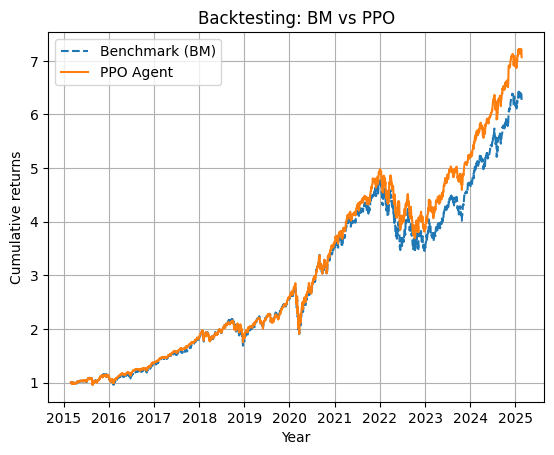

In [ ]:
# 오류때문에 backtest 함수를 재정의하고 plot하는 코드만 가져왔다:
##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # [수정됨] 평가 시에는 Dirichlet 분포의 평균(알파/합) 사용하여 결정론적 행동 선택
            dist = actor_model(state_tensor)
            action = (dist.concentration / dist.concentration.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()

        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot (연도별 표시)
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]
# 연도별로 X축 레이블을 표시하도록 설정
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

<ipython-input-5-9e5a460cd83d>:217: UserWarning: Using a target size (torch.Size([2511, 1])) that is different to the input size (torch.Size([2511])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


PPO Episode 0 | Reward: 2.4605 | Critic Loss: 0.0048
PPO Episode 1 | Reward: 2.3647 | Critic Loss: 0.0058
PPO Episode 2 | Reward: 1.8654 | Critic Loss: 0.0050
PPO Episode 3 | Reward: 2.0998 | Critic Loss: 0.0060
PPO Episode 4 | Reward: 1.9412 | Critic Loss: 0.0039
PPO Episode 5 | Reward: 2.1121 | Critic Loss: 0.0038
PPO Episode 6 | Reward: 2.1403 | Critic Loss: 0.0039
PPO Episode 7 | Reward: 2.2762 | Critic Loss: 0.0061
PPO Episode 8 | Reward: 2.3332 | Critic Loss: 0.0050
PPO Episode 9 | Reward: 2.2209 | Critic Loss: 0.0048
PPO Episode 10 | Reward: 2.6354 | Critic Loss: 0.0036
PPO Episode 11 | Reward: 2.4786 | Critic Loss: 0.0037
PPO Episode 12 | Reward: 1.9820 | Critic Loss: 0.0047
PPO Episode 13 | Reward: 1.9355 | Critic Loss: 0.0051
PPO Episode 14 | Reward: 2.3122 | Critic Loss: 0.0045
PPO Episode 15 | Reward: 2.3123 | Critic Loss: 0.0053
PPO Episode 16 | Reward: 2.0920 | Critic Loss: 0.0043
PPO Episode 17 | Reward: 1.9654 | Critic Loss: 0.0046
PPO Episode 18 | Reward: 2.2900 | Crit

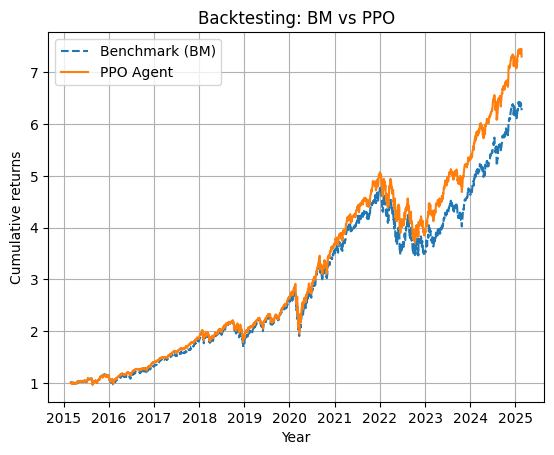

In [5]:
# 위 코드를 다시 전체 수정
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
"""
##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()
"""
##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Softmax 대신 Dirichlet 분포 + LSTM 추가
class Actor(nn.Module):
    """PPO 정책 네트워크 (행동 결정) - Dirichlet 분포 기반 with LSTM"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        # x: (batch, features)
        x = F.relu(self.fc1(x))
        # 시퀀스 길이가 1인 차원 추가: (batch, 1, hidden_dim)
        x = x.unsqueeze(1)
        lstm_out, hidden = self.lstm(x, hidden)  # lstm_out: (batch, 1, hidden_dim)
        lstm_out = lstm_out.squeeze(1)           # (batch, hidden_dim)
        alpha = self.softplus(self.fc2(lstm_out)) + 1e-6  # Dirichlet 파라미터 (양수 보장)
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크: LSTM 추가
class Critic(nn.Module):
    """PPO 가치 네트워크 (상태 가치 예측) with LSTM"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)  # (batch, 1, hidden_dim)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.squeeze(1)
        value = self.fc2(lstm_out)
        return value, hidden

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
entropy_coef = 0.01   # 엔트로피 보너스 계수

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
    """
    actor.train()  # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []  # [수정됨] 기존 행동의 로그 확률 저장 리스트
        state = env.reset()  # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False

        # 에피소드 진행 (Trajectory 수집)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist, _ = actor(state_tensor)           # [수정됨] Dirichlet 분포 객체 반환 + LSTM 사용 (hidden state는 생략)
            action = dist.sample()                  # [수정됨] 분포에서 샘플링
            log_prob = dist.log_prob(action)        # [수정됨] 로그 확률 계산

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        # 할인 누적 보상(Return) 계산
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        # [수정됨] 텐서 변환
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        # [수정됨] GAE (Generalized Advantage Estimation)를 통한 Advantage 계산
        with torch.no_grad():
            baseline_values, _ = critic(states_tensor)  # Critic 예측값, hidden 생략
            baseline_values = baseline_values.squeeze(1)
        gae_lambda = 0.95  # GAE 하이퍼파라미터
        rewards = torch.tensor(rewards, dtype=torch.float32)  # [수정됨] numpy 배열 → torch.Tensor 변환
        gae = 0
        advantages_list = []
        # rewards 리스트 길이와 baseline_values의 길이가 같다고 가정
        for t in reversed(range(len(rewards))):
            next_value = baseline_values[t + 1] if t < len(rewards) - 1 else torch.tensor(0.0)  # [수정됨] torch.Tensor로 변환
            delta = rewards[t] + gamma * next_value - baseline_values[t]
            gae = delta + gamma * gae_lambda * gae
            advantages_list.insert(0, gae)
        advantages = torch.stack(advantages_list)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO 업데이트 (K_epochs 반복)
        for _ in range(K_epochs):
            values, _ = critic(states_tensor)  # Critic 예측
            values = values.squeeze(1)
            dist, _ = actor(states_tensor)  # 새로운 분포 계산
            new_log_probs = dist.log_prob(actions_tensor)
            # [수정됨] 로그 확률 차이를 이용한 ratio 계산
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            # [수정됨] 엔트로피 보너스 추가 (탐색 유도)
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # [수정됨] 평가 시에는 Dirichlet 분포의 평균(즉, concentration / sum)을 사용하여 결정론적 행동 선택
            dist, _ = actor_model(state_tensor)
            action = (dist.concentration / dist.concentration.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()
        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot (연도별 표시)
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]
# 연도별로 X축 레이블을 표시하도록 설정
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed
<ipython-input-2-16861fa258ea>:175: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  returns = torch.tensor(returns, dtype=torch.float32)
<ipython-input-2-16861fa258ea>:213: UserWarning: Using a target size (torch.Size([2511, 1])) that is different to the input size (torch.Size([2511])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


PPO Episode 0 | Reward: 1.9806 | Critic Loss: 0.0040
PPO Episode 1 | Reward: 1.8050 | Critic Loss: 0.0053
PPO Episode 2 | Reward: 2.3891 | Critic Loss: 0.0049
PPO Episode 3 | Reward: 2.4166 | Critic Loss: 0.0041
PPO Episode 4 | Reward: 2.0199 | Critic Loss: 0.0045
PPO Episode 5 | Reward: 1.7125 | Critic Loss: 0.0051
PPO Episode 6 | Reward: 2.1892 | Critic Loss: 0.0035
PPO Episode 7 | Reward: 2.3521 | Critic Loss: 0.0035
PPO Episode 8 | Reward: 2.1648 | Critic Loss: 0.0038
PPO Episode 9 | Reward: 2.2670 | Critic Loss: 0.0056
PPO Episode 10 | Reward: 2.1504 | Critic Loss: 0.0048
PPO Episode 11 | Reward: 2.0434 | Critic Loss: 0.0043
PPO Episode 12 | Reward: 2.4853 | Critic Loss: 0.0042
PPO Episode 13 | Reward: 2.2133 | Critic Loss: 0.0048
PPO Episode 14 | Reward: 2.0354 | Critic Loss: 0.0049
PPO Episode 15 | Reward: 2.3297 | Critic Loss: 0.0038
PPO Episode 16 | Reward: 1.9495 | Critic Loss: 0.0027
PPO Episode 17 | Reward: 2.0977 | Critic Loss: 0.0048
PPO Episode 18 | Reward: 2.2626 | Crit

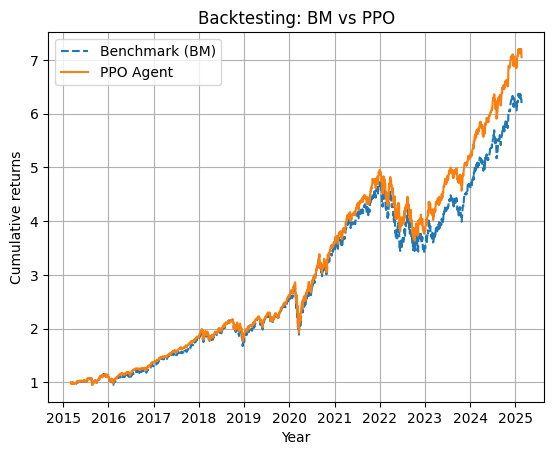

In [2]:
# LSTM 대신 GRU 로 학습을 진행하는 코드
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
returns_df = data.pct_change().dropna()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # 주어진 수익률 데이터
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Softmax 대신 Dirichlet 분포 + GRU 사용 (LSTM → GRU)
class Actor(nn.Module):
    """PPO 정책 네트워크 (행동 결정) - Dirichlet 분포 기반 with GRU"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # [수정됨] LSTM → GRU
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        # x: (batch, features)
        x = F.relu(self.fc1(x))
        # 시퀀스 길이가 1인 차원 추가: (batch, 1, hidden_dim)
        x = x.unsqueeze(1)
        gru_out, hidden = self.gru(x, hidden)  # [수정됨] LSTM 호출 → GRU 호출; gru_out: (batch, 1, hidden_dim)
        gru_out = gru_out.squeeze(1)           # (batch, hidden_dim)
        alpha = self.softplus(self.fc2(gru_out)) + 1e-6  # Dirichlet 파라미터 (양수 보장)
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크: GRU 사용 (LSTM → GRU)
class Critic(nn.Module):
    """PPO 가치 네트워크 (상태 가치 예측) with GRU"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # [수정됨] LSTM → GRU
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)  # (batch, 1, hidden_dim)
        gru_out, hidden = self.gru(x, hidden)  # [수정됨] LSTM 호출 → GRU 호출
        gru_out = gru_out.squeeze(1)
        value = self.fc2(gru_out)
        return value, hidden

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
entropy_coef = 0.01   # 엔트로피 보너스 계수

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
    """
    actor.train()  # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []  # [수정됨] 기존 행동의 로그 확률 저장 리스트
        state = env.reset()  # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False

        # 에피소드 진행 (Trajectory 수집)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist, _ = actor(state_tensor)           # [수정됨] Dirichlet 분포 객체 반환 + GRU 사용 (hidden state는 생략)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        # 할인 누적 보상(Return) 계산
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        # 텐서 변환
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        # [수정됨] GAE (Generalized Advantage Estimation)를 통한 Advantage 계산
        with torch.no_grad():
            baseline_values, _ = critic(states_tensor)  # Critic 예측값, hidden 생략
            baseline_values = baseline_values.squeeze(1)
        gae_lambda = 0.95  # GAE 하이퍼파라미터
        rewards = torch.tensor(rewards, dtype=torch.float32)  # [수정됨] numpy 배열 → torch.Tensor 변환
        gae = 0
        advantages_list = []
        # rewards 리스트 길이와 baseline_values의 길이가 같다고 가정
        for t in reversed(range(len(rewards))):
            next_value = baseline_values[t + 1] if t < len(rewards) - 1 else torch.tensor(0.0, dtype=torch.float32)  # [수정됨]
            delta = rewards[t] + gamma * next_value - baseline_values[t]
            gae = delta + gamma * gae_lambda * gae
            advantages_list.insert(0, gae)
        advantages = torch.stack(advantages_list)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO 업데이트 (K_epochs 반복)
        for _ in range(K_epochs):
            values, _ = critic(states_tensor)  # [수정됨] Critic 예측
            values = values.squeeze(1)
            dist, _ = actor(states_tensor)  # 새로운 분포 계산
            new_log_probs = dist.log_prob(actions_tensor)
            # [수정됨] 로그 확률 차이를 이용한 ratio 계산
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            # [수정됨] 엔트로피 보너스 추가 (탐색 유도)
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # [수정됨] 평가 시에는 Dirichlet 분포의 평균(즉, concentration / sum)을 사용하여 결정론적 행동 선택
            dist, _ = actor_model(state_tensor)
            action = (dist.concentration / dist.concentration.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()
        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot (연도별 표시)
##############################################
ppo_daily_returns = backtest(actor, returns_np)
ppo_cumulative = np.cumprod(1 + ppo_daily_returns)

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
benchmark_cumulative = np.cumprod(1 + benchmark_daily)

dates = data.index[:len(ppo_daily_returns)]
# 연도별로 X축 레이블을 표시하도록 설정
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

In [3]:
##############################################
# [수정됨] 추가: 포트폴리오 최적화 성능 평가 지표 계산 및 출력
##############################################
import math

def annualized_sharpe(returns, risk_free_rate=0):
    mean_ret = np.mean(returns) - risk_free_rate/252
    std_ret = np.std(returns)
    sharpe = (mean_ret / std_ret) * math.sqrt(252) if std_ret != 0 else np.nan
    return sharpe

def annualized_sortino(returns, risk_free_rate=0):
    mean_ret = np.mean(returns) - risk_free_rate/252
    downside_returns = returns[returns < 0]
    if len(downside_returns) == 0:
        return np.nan
    downside_std = np.std(downside_returns)
    sortino = (mean_ret / downside_std) * math.sqrt(252)
    return sortino

def max_drawdown(cum_returns):
    running_max = np.maximum.accumulate(cum_returns)
    drawdowns = (running_max - cum_returns) / running_max
    return np.max(drawdowns)

def annualized_volatility(returns):
    return np.std(returns) * math.sqrt(252)

def value_at_risk(returns, confidence=0.95):
    var = np.percentile(returns, (1 - confidence) * 100)
    return var

# 계산: PPO 포트폴리오
ppo_sharpe = annualized_sharpe(ppo_daily_returns)
ppo_sortino = annualized_sortino(ppo_daily_returns)
ppo_volatility = annualized_volatility(ppo_daily_returns)
ppo_max_drawdown = max_drawdown(ppo_cumulative)
ppo_var = value_at_risk(ppo_daily_returns, confidence=0.95)

# 계산: 벤치마크 포트폴리오
bench_sharpe = annualized_sharpe(benchmark_daily)
bench_sortino = annualized_sortino(benchmark_daily)
bench_volatility = annualized_volatility(benchmark_daily)
bench_max_drawdown = max_drawdown(benchmark_cumulative)
bench_var = value_at_risk(benchmark_daily, confidence=0.95)

print("PPO Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {ppo_sharpe:.4f}")
print(f"Annualized Sortino Ratio: {ppo_sortino:.4f}")
print(f"Annualized Volatility: {ppo_volatility:.4f}")
print(f"Maximum Drawdown: {ppo_max_drawdown:.4f}")
print(f"VaR (95% confidence): {ppo_var:.4f}\n")

print("Benchmark Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {bench_sharpe:.4f}")
print(f"Annualized Sortino Ratio: {bench_sortino:.4f}")
print(f"Annualized Volatility: {bench_volatility:.4f}")
print(f"Maximum Drawdown: {bench_max_drawdown:.4f}")
print(f"VaR (95% confidence): {bench_var:.4f}")

PPO Portfolio Performance Metrics:
Annualized Sharpe Ratio: 1.1371
Annualized Sortino Ratio: 1.3827
Annualized Volatility: 0.1880
Maximum Drawdown: 0.3277
VaR (95% confidence): -0.0171

Benchmark Portfolio Performance Metrics:
Annualized Sharpe Ratio: 1.0399
Annualized Sortino Ratio: 1.2764
Annualized Volatility: 0.1947
Maximum Drawdown: 0.3133
VaR (95% confidence): -0.0186


<ipython-input-5-5d39d59b05bd>:214: UserWarning: Using a target size (torch.Size([2511, 1])) that is different to the input size (torch.Size([2511])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-5-5d39d59b05bd>:224: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


PPO Episode 0 | Reward: 1.7026 | Critic Loss: 0.0039
PPO Episode 1 | Reward: 1.5778 | Critic Loss: 0.0055
PPO Episode 2 | Reward: 2.1548 | Critic Loss: 0.0048
PPO Episode 3 | Reward: 1.7496 | Critic Loss: 0.0038
PPO Episode 4 | Reward: 1.7499 | Critic Loss: 0.0047
PPO Episode 5 | Reward: 1.7557 | Critic Loss: 0.0049
PPO Episode 6 | Reward: 1.5478 | Critic Loss: 0.0056
PPO Episode 7 | Reward: 1.7106 | Critic Loss: 0.0042
PPO Episode 8 | Reward: 1.4237 | Critic Loss: 0.0061
PPO Episode 9 | Reward: 1.8312 | Critic Loss: 0.0045
PPO Episode 10 | Reward: 2.1573 | Critic Loss: 0.0043
PPO Episode 11 | Reward: 1.6462 | Critic Loss: 0.0045
PPO Episode 12 | Reward: 1.7242 | Critic Loss: 0.0041
PPO Episode 13 | Reward: 1.5225 | Critic Loss: 0.0044
PPO Episode 14 | Reward: 1.4247 | Critic Loss: 0.0042
PPO Episode 15 | Reward: 1.5478 | Critic Loss: 0.0049
PPO Episode 16 | Reward: 1.5022 | Critic Loss: 0.0044
PPO Episode 17 | Reward: 1.5590 | Critic Loss: 0.0057
PPO Episode 18 | Reward: 1.5938 | Crit

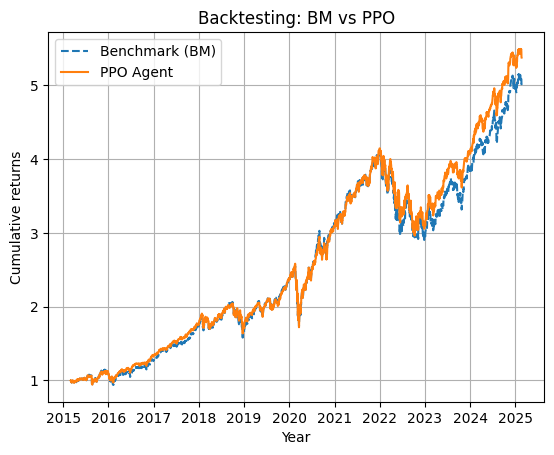

PPO Portfolio Performance Metrics:
Annualized Sharpe Ratio: 0.8995
Annualized Sortino Ratio: 1.0616
Annualized Volatility: 0.1877
Maximum Drawdown: 0.3339
VaR (95% confidence): -0.0173

Benchmark Portfolio Performance Metrics:
Annualized Sharpe Ratio: 0.8296
Annualized Sortino Ratio: 0.9899
Annualized Volatility: 0.1953
Maximum Drawdown: 0.3186
VaR (95% confidence): -0.0189


In [5]:
# 기존 수익율 대신 log 수익률로 수정한 코드
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
"""
##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)"""
# [수정됨] pct_change() 대신 log return 계산
returns_df = np.log(data / data.shift(1)).dropna()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # 주어진 수익률 데이터 (log return)
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 log 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 log 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Softmax 대신 Dirichlet 분포 + GRU 사용 (LSTM → GRU)
class Actor(nn.Module):
    """PPO 정책 네트워크 (행동 결정) - Dirichlet 분포 기반 with GRU"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # [수정됨] GRU 사용
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        # x: (batch, features)
        x = F.relu(self.fc1(x))
        # 시퀀스 길이가 1인 차원 추가: (batch, 1, hidden_dim)
        x = x.unsqueeze(1)
        gru_out, hidden = self.gru(x, hidden)  # [수정됨] GRU 호출
        gru_out = gru_out.squeeze(1)           # (batch, hidden_dim)
        alpha = self.softplus(self.fc2(gru_out)) + 1e-6  # Dirichlet 파라미터 (양수 보장)
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크: GRU 사용 (LSTM → GRU)
class Critic(nn.Module):
    """PPO 가치 네트워크 (상태 가치 예측) with GRU"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # [수정됨] GRU 사용
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)  # (batch, 1, hidden_dim)
        gru_out, hidden = self.gru(x, hidden)  # [수정됨] GRU 호출
        gru_out = gru_out.squeeze(1)
        value = self.fc2(gru_out)
        return value, hidden

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
entropy_coef = 0.01   # 엔트로피 보너스 계수

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
    """
    actor.train()  # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []  # [수정됨] 기존 행동의 로그 확률 저장 리스트
        state = env.reset()  # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False

        # 에피소드 진행 (Trajectory 수집)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist, _ = actor(state_tensor)           # [수정됨] Dirichlet 분포 객체 반환 + GRU 사용 (hidden state는 생략)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        # 할인 누적 보상(Return) 계산 (log 수익률이므로, 누적 log return)
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        # 텐서 변환
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        # [수정됨] GAE (Generalized Advantage Estimation)를 통한 Advantage 계산
        with torch.no_grad():
            baseline_values, _ = critic(states_tensor)  # Critic 예측값, hidden 생략
            baseline_values = baseline_values.squeeze(1)
        gae_lambda = 0.95  # GAE 하이퍼파라미터
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)  # [수정됨] numpy 배열 → torch.Tensor 변환
        gae = 0
        advantages_list = []
        # rewards의 길이와 baseline_values의 길이가 같다고 가정
        for t in reversed(range(len(rewards_tensor))):
            next_value = baseline_values[t + 1] if t < len(rewards_tensor) - 1 else torch.tensor(0.0, dtype=torch.float32)  # [수정됨]
            delta = rewards_tensor[t] + gamma * next_value - baseline_values[t]
            gae = delta + gamma * gae_lambda * gae
            advantages_list.insert(0, gae)
        advantages = torch.stack(advantages_list)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO 업데이트 (K_epochs 반복)
        for _ in range(K_epochs):
            values, _ = critic(states_tensor)  # [수정됨] Critic 예측
            values = values.squeeze(1)
            dist, _ = actor(states_tensor)  # 새로운 분포 계산
            new_log_probs = dist.log_prob(actions_tensor)
            # [수정됨] 로그 확률 차이를 이용한 ratio 계산
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            # [수정됨] 엔트로피 보너스 추가 (탐색 유도)
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # [수정됨] 평가 시에는 Dirichlet 분포의 평균(즉, concentration / sum)을 사용하여 결정론적 행동 선택
            dist, _ = actor_model(state_tensor)
            action = (dist.concentration / dist.concentration.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()
        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot (연도별 표시)
##############################################
ppo_daily_returns = backtest(actor, returns_np)
# [수정됨] log 수익률의 누적 합을 지수함수로 변환하여 누적 수익률 계산
ppo_cumulative = np.exp(np.cumsum(ppo_daily_returns))

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
# [수정됨] 벤치마크 누적 수익률 계산 시, log 수익률 사용
benchmark_cumulative = np.exp(np.cumsum(benchmark_daily))

dates = data.index[:len(ppo_daily_returns)]
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

##############################################
# [수정됨] 추가: 포트폴리오 최적화 성능 평가 지표 계산 및 출력
##############################################
import math

def annualized_sharpe(returns, risk_free_rate=0):
    mean_ret = np.mean(returns) - risk_free_rate/252
    std_ret = np.std(returns)
    sharpe = (mean_ret / std_ret) * math.sqrt(252) if std_ret != 0 else np.nan
    return sharpe

def annualized_sortino(returns, risk_free_rate=0):
    mean_ret = np.mean(returns) - risk_free_rate/252
    downside_returns = returns[returns < 0]
    if len(downside_returns) == 0:
        return np.nan
    downside_std = np.std(downside_returns)
    sortino = (mean_ret / downside_std) * math.sqrt(252)
    return sortino

def max_drawdown(cum_returns):
    running_max = np.maximum.accumulate(cum_returns)
    drawdowns = (running_max - cum_returns) / running_max
    return np.max(drawdowns)

def annualized_volatility(returns):
    return np.std(returns) * math.sqrt(252)

def value_at_risk(returns, confidence=0.95):
    var = np.percentile(returns, (1 - confidence) * 100)
    return var

# 계산: PPO 포트폴리오
ppo_sharpe = annualized_sharpe(ppo_daily_returns)
ppo_sortino = annualized_sortino(ppo_daily_returns)
ppo_volatility = annualized_volatility(ppo_daily_returns)
ppo_max_drawdown = max_drawdown(ppo_cumulative)
ppo_var = value_at_risk(ppo_daily_returns, confidence=0.95)

# 계산: 벤치마크 포트폴리오
bench_sharpe = annualized_sharpe(benchmark_daily)
bench_sortino = annualized_sortino(benchmark_daily)
bench_volatility = annualized_volatility(benchmark_daily)
bench_max_drawdown = max_drawdown(benchmark_cumulative)
bench_var = value_at_risk(benchmark_daily, confidence=0.95)

print("PPO Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {ppo_sharpe:.4f}")
print(f"Annualized Sortino Ratio: {ppo_sortino:.4f}")
print(f"Annualized Volatility: {ppo_volatility:.4f}")
print(f"Maximum Drawdown: {ppo_max_drawdown:.4f}")
print(f"VaR (95% confidence): {ppo_var:.4f}\n")

print("Benchmark Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {bench_sharpe:.4f}")
print(f"Annualized Sortino Ratio: {bench_sortino:.4f}")
print(f"Annualized Volatility: {bench_volatility:.4f}")
print(f"Maximum Drawdown: {bench_max_drawdown:.4f}")
print(f"VaR (95% confidence): {bench_var:.4f}")

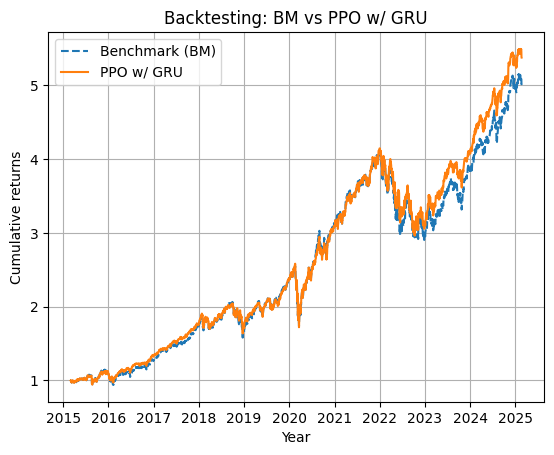

In [13]:
# format 맞추도록 수정하고 플롯
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO w/ GRU")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO w/ GRU")
plt.grid(True)
plt.show()

<ipython-input-14-5f75168876d3>:215: UserWarning: Using a target size (torch.Size([2511, 1])) that is different to the input size (torch.Size([2511])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)


PPO Episode 0 | Reward: 2.0107 | Critic Loss: 0.0053
PPO Episode 1 | Reward: 1.7054 | Critic Loss: 0.0045
PPO Episode 2 | Reward: 1.5531 | Critic Loss: 0.0046
PPO Episode 3 | Reward: 1.5069 | Critic Loss: 0.0039
PPO Episode 4 | Reward: 1.4207 | Critic Loss: 0.0041
PPO Episode 5 | Reward: 1.8274 | Critic Loss: 0.0049
PPO Episode 6 | Reward: 1.8564 | Critic Loss: 0.0039
PPO Episode 7 | Reward: 1.8649 | Critic Loss: 0.0043
PPO Episode 8 | Reward: 1.3378 | Critic Loss: 0.0054
PPO Episode 9 | Reward: 1.7316 | Critic Loss: 0.0045
PPO Episode 10 | Reward: 1.4783 | Critic Loss: 0.0058
PPO Episode 11 | Reward: 1.6550 | Critic Loss: 0.0057
PPO Episode 12 | Reward: 2.1604 | Critic Loss: 0.0044
PPO Episode 13 | Reward: 1.1368 | Critic Loss: 0.0047
PPO Episode 14 | Reward: 1.3677 | Critic Loss: 0.0047
PPO Episode 15 | Reward: 1.9915 | Critic Loss: 0.0048
PPO Episode 16 | Reward: 1.5796 | Critic Loss: 0.0069
PPO Episode 17 | Reward: 1.8179 | Critic Loss: 0.0041
PPO Episode 18 | Reward: 1.8821 | Crit

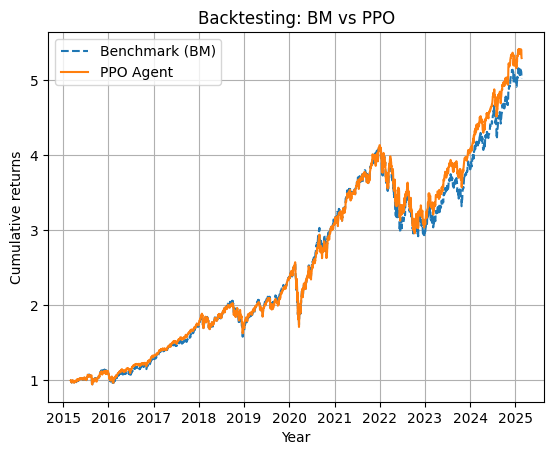

PPO Portfolio Performance Metrics:
Annualized Sharpe Ratio: 0.8886
Annualized Sortino Ratio: 1.0501
Annualized Volatility: 0.1881
Maximum Drawdown: 0.3354
VaR (95% confidence): -0.0174

Benchmark Portfolio Performance Metrics:
Annualized Sharpe Ratio: 0.8296
Annualized Sortino Ratio: 0.9899
Annualized Volatility: 0.1953
Maximum Drawdown: 0.3186
VaR (95% confidence): -0.0189


In [14]:
# 위 GRU + log 수익률 코드를 다시 수정해서 LSTM을 사용하도록 변경
# 기존 수익율 대신 log 수익률로 수정한 코드
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
"""
##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)"""
# [수정됨] pct_change() 대신 log return 계산
returns_df = np.log(data / data.shift(1)).dropna()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # 주어진 수익률 데이터 (log return)
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns[self.current_step]

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns[self.current_step]  # 현재 log 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 log 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)  # 마지막 스텝 여부 확인
        next_state = self.returns[self.current_step] if not done else np.zeros(self.n_assets)  # 종료 시 0 반환
        return next_state, reward, done, {}

returns_np = returns_df.values  # NumPy 배열 변환

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Softmax 대신 Dirichlet 분포 + LSTM 추가
class Actor(nn.Module):
    """PPO 정책 네트워크 (행동 결정) - Dirichlet 분포 기반 with LSTM"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        # x: (batch, features)
        x = F.relu(self.fc1(x))
        # 시퀀스 길이가 1인 차원 추가: (batch, 1, hidden_dim)
        x = x.unsqueeze(1)
        lstm_out, hidden = self.lstm(x, hidden)  # lstm_out: (batch, 1, hidden_dim)
        lstm_out = lstm_out.squeeze(1)           # (batch, hidden_dim)
        alpha = self.softplus(self.fc2(lstm_out)) + 1e-6  # Dirichlet 파라미터 (양수 보장)
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크: LSTM 추가
class Critic(nn.Module):
    """PPO 가치 네트워크 (상태 가치 예측) with LSTM"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)  # (batch, 1, hidden_dim)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.squeeze(1)
        value = self.fc2(lstm_out)
        return value, hidden

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2         # PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
K_epochs = 10         # 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
entropy_coef = 0.01   # 엔트로피 보너스 계수

# 네트워크 및 옵티마이저 초기화
input_dim = returns_np.shape[1]
hidden_dim = 64
output_dim = returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    """
    PPO 알고리즘을 이용한 학습 함수
    - epsilon: PPO 클리핑 파라미터 (정책 업데이트 제한, 기본값 0.2)
    - K_epochs: 하나의 에피소드에서 PPO 업데이트 반복 횟수 (기본값 10)
    """
    actor.train()  # Actor, Critic 네트워크를 학습 모드로 설정
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []  # [수정됨] 기존 행동의 로그 확률 저장 리스트
        state = env.reset()  # 환경 초기화 및 첫 번째 상태(state) 가져오기
        done = False

        # 에피소드 진행 (Trajectory 수집)
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist, _ = actor(state_tensor)           # [수정됨] Dirichlet 분포 객체 반환 + LSTM 사용 (hidden state는 생략)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        # 할인 누적 보상(Return) 계산 (log 수익률이므로, 누적 log return)
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        # 텐서 변환
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        # [수정됨] GAE (Generalized Advantage Estimation)를 통한 Advantage 계산
        with torch.no_grad():
            baseline_values, _ = critic(states_tensor)  # Critic 예측값, hidden 생략
            baseline_values = baseline_values.squeeze(1)
        gae_lambda = 0.95  # GAE 하이퍼파라미터
        rewards = torch.tensor(rewards, dtype=torch.float32)  # [수정됨] numpy 배열 → torch.Tensor 변환
        gae = 0
        advantages_list = []
        # rewards 리스트 길이와 baseline_values의 길이가 같다고 가정
        for t in reversed(range(len(rewards))):
            next_value = baseline_values[t + 1] if t < len(rewards) - 1 else torch.tensor(0.0)  # [수정됨] torch.Tensor로 변환
            delta = rewards[t] + gamma * next_value - baseline_values[t]
            gae = delta + gamma * gae_lambda * gae
            advantages_list.insert(0, gae)
        advantages = torch.stack(advantages_list)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO 업데이트 (K_epochs 반복)
        for _ in range(K_epochs):
            values, _ = critic(states_tensor)  # [수정됨] Critic 예측
            values = values.squeeze(1)
            dist, _ = actor(states_tensor)  # 새로운 분포 계산
            new_log_probs = dist.log_prob(actions_tensor)
            # [수정됨] 로그 확률 차이를 이용한 ratio 계산
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            # [수정됨] 엔트로피 보너스 추가 (탐색 유도)
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

actor = train_ppo(num_episodes, HistoricalPortfolioEnv(returns_np), actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 전체 기간에 대해 포트폴리오 수익률 산출
##############################################
def backtest(actor_model, returns_np):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_np)
    state = env_bt.reset()
    daily_returns = []

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # [수정됨] 평가 시에는 Dirichlet 분포의 평균(즉, concentration / sum)을 사용하여 결정론적 행동 선택
            dist, _ = actor_model(state_tensor)
            action = (dist.concentration / dist.concentration.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()
        next_state, reward, done, _ = env_bt.step(action)
        daily_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(daily_returns)

##############################################
# 6. 백테스팅 및 결과 Plot (연도별 표시)
##############################################
ppo_daily_returns = backtest(actor, returns_np)
# [수정됨] log 수익률의 누적 합을 지수함수로 변환하여 누적 수익률 계산
ppo_cumulative = np.exp(np.cumsum(ppo_daily_returns))

benchmark_daily = returns_df.dot(benchmark_weights).values[-len(ppo_daily_returns):]
# [수정됨] 벤치마크 누적 수익률 계산 시, log 수익률 사용
benchmark_cumulative = np.exp(np.cumsum(benchmark_daily))

dates = data.index[:len(ppo_daily_returns)]
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO Agent")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

##############################################
# [수정됨] 추가: 포트폴리오 최적화 성능 평가 지표 계산 및 출력
##############################################
import math

def annualized_sharpe(returns, risk_free_rate=0):
    mean_ret = np.mean(returns) - risk_free_rate/252
    std_ret = np.std(returns)
    sharpe = (mean_ret / std_ret) * math.sqrt(252) if std_ret != 0 else np.nan
    return sharpe

def annualized_sortino(returns, risk_free_rate=0):
    mean_ret = np.mean(returns) - risk_free_rate/252
    downside_returns = returns[returns < 0]
    if len(downside_returns) == 0:
        return np.nan
    downside_std = np.std(downside_returns)
    sortino = (mean_ret / downside_std) * math.sqrt(252)
    return sortino

def max_drawdown(cum_returns):
    running_max = np.maximum.accumulate(cum_returns)
    drawdowns = (running_max - cum_returns) / running_max
    return np.max(drawdowns)

def annualized_volatility(returns):
    return np.std(returns) * math.sqrt(252)

def value_at_risk(returns, confidence=0.95):
    var = np.percentile(returns, (1 - confidence) * 100)
    return var

# 계산: PPO 포트폴리오
ppo_sharpe = annualized_sharpe(ppo_daily_returns)
ppo_sortino = annualized_sortino(ppo_daily_returns)
ppo_volatility = annualized_volatility(ppo_daily_returns)
ppo_max_drawdown = max_drawdown(ppo_cumulative)
ppo_var = value_at_risk(ppo_daily_returns, confidence=0.95)

# 계산: 벤치마크 포트폴리오
bench_sharpe = annualized_sharpe(benchmark_daily)
bench_sortino = annualized_sortino(benchmark_daily)
bench_volatility = annualized_volatility(benchmark_daily)
bench_max_drawdown = max_drawdown(benchmark_cumulative)
bench_var = value_at_risk(benchmark_daily, confidence=0.95)

print("PPO Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {ppo_sharpe:.4f}")
print(f"Annualized Sortino Ratio: {ppo_sortino:.4f}")
print(f"Annualized Volatility: {ppo_volatility:.4f}")
print(f"Maximum Drawdown: {ppo_max_drawdown:.4f}")
print(f"VaR (95% confidence): {ppo_var:.4f}\n")

print("Benchmark Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {bench_sharpe:.4f}")
print(f"Annualized Sortino Ratio: {bench_sortino:.4f}")
print(f"Annualized Volatility: {bench_volatility:.4f}")
print(f"Maximum Drawdown: {bench_max_drawdown:.4f}")
print(f"VaR (95% confidence): {bench_var:.4f}")

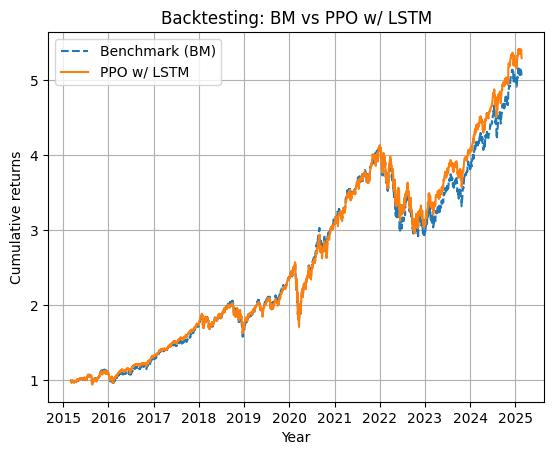

In [15]:
# format 맞추도록 수정하고 플롯
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(dates, ppo_cumulative, label="PPO w/ LSTM")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO w/ LSTM")
plt.grid(True)
plt.show()

<ipython-input-16-64839ef8dbf4>:213: UserWarning: Using a target size (torch.Size([417, 1])) that is different to the input size (torch.Size([417])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-16-64839ef8dbf4>:223: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


PPO Episode 0 | Reward: 1.2702 | Critic Loss: 0.0349
PPO Episode 1 | Reward: 1.4374 | Critic Loss: 0.0329
PPO Episode 2 | Reward: 1.0823 | Critic Loss: 0.0240
PPO Episode 3 | Reward: 0.8835 | Critic Loss: 0.0240
PPO Episode 4 | Reward: 1.1081 | Critic Loss: 0.0289
PPO Episode 5 | Reward: 1.4756 | Critic Loss: 0.0524
PPO Episode 6 | Reward: 1.2161 | Critic Loss: 0.0275
PPO Episode 7 | Reward: 1.4046 | Critic Loss: 0.0379
PPO Episode 8 | Reward: 1.4726 | Critic Loss: 0.0360
PPO Episode 9 | Reward: 0.8963 | Critic Loss: 0.0354
PPO Episode 10 | Reward: 1.3149 | Critic Loss: 0.0403
PPO Episode 11 | Reward: 1.2522 | Critic Loss: 0.0403
PPO Episode 12 | Reward: 1.1673 | Critic Loss: 0.0299
PPO Episode 13 | Reward: 1.3884 | Critic Loss: 0.0354
PPO Episode 14 | Reward: 1.1108 | Critic Loss: 0.0195
PPO Episode 15 | Reward: 1.1374 | Critic Loss: 0.0410
PPO Episode 16 | Reward: 0.9224 | Critic Loss: 0.0374
PPO Episode 17 | Reward: 1.2186 | Critic Loss: 0.0298
PPO Episode 18 | Reward: 1.4646 | Crit

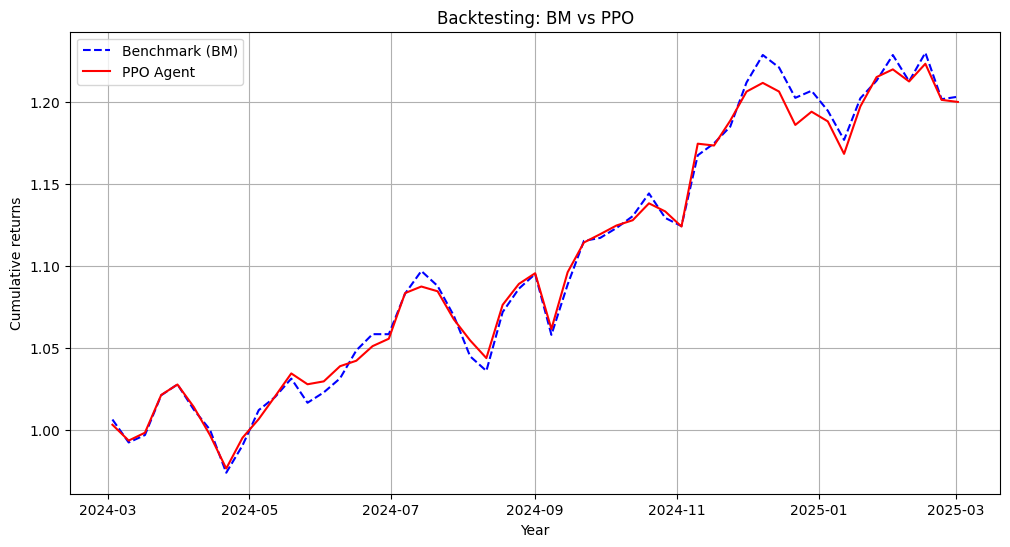

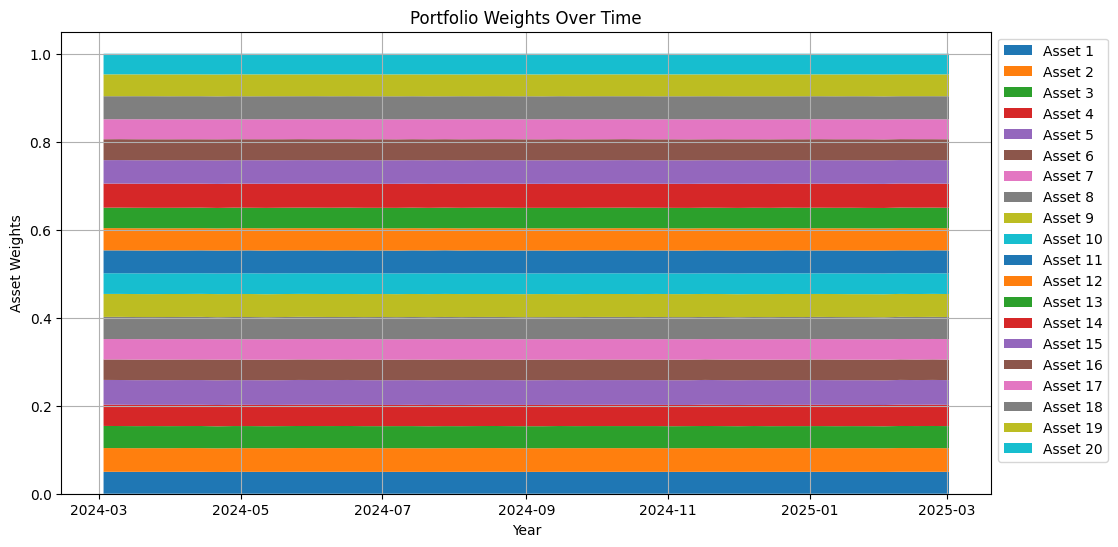

PPO Portfolio Performance Metrics:
Annualized Sharpe Ratio: 3.7637
Annualized Sortino Ratio: 7.1852
Annualized Volatility: 0.2302
Maximum Drawdown: 0.0498
VaR (95% confidence): -0.0175

Benchmark Portfolio Performance Metrics:
Annualized Sharpe Ratio: 3.4780
Annualized Sortino Ratio: 7.0059
Annualized Volatility: 0.2528
Maximum Drawdown: 0.0555
VaR (95% confidence): -0.0233


In [16]:
# 리밸런싱은 매주 진행하고, 데이터셋을 8 : 1 : 1 비율로 train : validation : test 셋으로 나누도록 변경.
# 그리고 plot할 때, 포트폴리오의 비중을 기간별로 plot해주는 코드
# 여기선 다시 GRU 사용
"""import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)"""
# [수정됨] Log return 계산 (일별)
returns_df = np.log(data / data.shift(1)).dropna()

# [수정됨] 일별 데이터를 주별 데이터로 변환 (log returns는 합산하면 됨)
weekly_returns_df = returns_df.resample('W').sum()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

# [수정됨] 데이터셋 분할: 8:1:1 비율 (train : validation : test)
n = len(weekly_returns_df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)
train_returns = weekly_returns_df.iloc[:train_end]
val_returns = weekly_returns_df.iloc[train_end:val_end]
test_returns = weekly_returns_df.iloc[val_end:]

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # 주어진 수익률 데이터 (log returns, 주별)
        self.n_assets = returns.shape[1]  # 자산 개수
        self.current_step = 0
        # 관측 공간: 각 자산의 log 수익률 (실수값 범위)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        # 액션 공간: 각 자산의 비중 (0~1 사이)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        """환경 초기화 및 첫 번째 상태 반환"""
        self.current_step = 0
        return self.returns.iloc[self.current_step].values

    def step(self, action):
        """주어진 액션(포트폴리오 비중)에 대해 보상을 계산하고 다음 상태 반환"""
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns.iloc[self.current_step].values  # 현재 log 수익률
        reward = np.dot(weights, current_return)  # 포트폴리오 log 수익률 계산
        self.current_step += 1  # 다음 스텝으로 이동
        done = self.current_step >= len(self.returns)
        next_state = self.returns.iloc[self.current_step].values if not done else np.zeros(self.n_assets)
        return next_state, reward, done, {}

# 학습에는 train set 사용
train_returns_np = train_returns.values

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Dirichlet 분포 + GRU 사용
class Actor(nn.Module):
    """PPO 정책 네트워크 (행동 결정) - Dirichlet 분포 기반 with GRU"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU 사용
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)  # (batch, 1, hidden_dim)
        gru_out, hidden = self.gru(x, hidden)  # GRU 호출
        gru_out = gru_out.squeeze(1)           # (batch, hidden_dim)
        alpha = self.softplus(self.fc2(gru_out)) + 1e-6  # Dirichlet 파라미터 (양수 보장)
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크: GRU 사용
class Critic(nn.Module):
    """PPO 가치 네트워크 (상태 가치 예측) with GRU"""
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU 사용
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)
        gru_out, hidden = self.gru(x, hidden)
        gru_out = gru_out.squeeze(1)
        value = self.fc2(gru_out)
        return value, hidden

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2
K_epochs = 10
entropy_coef = 0.01

input_dim = train_returns_np.shape[1]
hidden_dim = 64
output_dim = train_returns_np.shape[1]

actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    actor.train()
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []
        state = env.reset()
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist, _ = actor(state_tensor)  # Dirichlet 분포 + GRU 사용
            action = dist.sample()
            log_prob = dist.log_prob(action)

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        # 할인 누적 보상 계산 (log returns 누적)
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        # [수정됨] GAE (Generalized Advantage Estimation) 계산
        with torch.no_grad():
            baseline_values, _ = critic(states_tensor)
            baseline_values = baseline_values.squeeze(1)
        gae_lambda = 0.95
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        gae = 0
        advantages_list = []
        for t in reversed(range(len(rewards_tensor))):
            next_value = baseline_values[t + 1] if t < len(rewards_tensor) - 1 else torch.tensor(0.0, dtype=torch.float32)
            delta = rewards_tensor[t] + gamma * next_value - baseline_values[t]
            gae = delta + gamma * gae_lambda * gae
            advantages_list.insert(0, gae)
        advantages = torch.stack(advantages_list)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(K_epochs):
            values, _ = critic(states_tensor)
            values = values.squeeze(1)
            dist, _ = actor(states_tensor)
            new_log_probs = dist.log_prob(actions_tensor)
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy

            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

train_env = HistoricalPortfolioEnv(train_returns)  # Train set 환경 사용
actor = train_ppo(num_episodes, train_env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

##############################################
# 5-1. 백테스팅: 학습된 Actor 네트워크로 포트폴리오 수익률 및 비중 산출 (Test set 사용)
##############################################
def backtest(actor_model, returns_df):
    actor_model.eval()
    env_bt = HistoricalPortfolioEnv(returns_df)
    state = env_bt.reset()
    weekly_returns = []
    weights_over_time = []  # [수정됨] 포트폴리오 비중 기록

    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            dist, _ = actor_model(state_tensor)
            # [수정됨] 결정론적 행동: Dirichlet 분포의 평균 (concentration / sum)
            action = (dist.concentration / dist.concentration.sum(dim=-1, keepdim=True)).cpu().data.numpy().flatten()
        weights_over_time.append(action)
        next_state, reward, done, _ = env_bt.step(action)
        weekly_returns.append(reward)
        if done:
            break
        state = next_state
    return np.array(weekly_returns), np.array(weights_over_time)

# Test set 사용
test_returns_np = test_returns.values
ppo_weekly_returns, portfolio_weights = backtest(actor, test_returns)
# [수정됨] 누적 수익률 계산: log returns 누적합을 지수함수로 변환
ppo_cumulative = np.exp(np.cumsum(ppo_weekly_returns))

benchmark_weekly = test_returns.dot(benchmark_weights).values[-len(ppo_weekly_returns):]
benchmark_cumulative = np.exp(np.cumsum(benchmark_weekly))

dates = test_returns.index[:len(ppo_weekly_returns)]
plt.figure(figsize=(12,6))
plt.plot(dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--", color="blue")
plt.plot(dates, ppo_cumulative, label="PPO Agent", color="red")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cumulative returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

##############################################
# [수정됨] 포트폴리오 비중 Plot (기간별)
##############################################
plt.figure(figsize=(12,6))
# Stacked area plot for portfolio weights over time
# portfolio_weights shape: (time_steps, n_assets)
weights = portfolio_weights.T  # 각 행: asset, 각 열: time step
plt.stackplot(dates, weights, labels=[f"Asset {i+1}" for i in range(weights.shape[0])])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Year")
plt.ylabel("Asset Weights")
plt.title("Portfolio Weights Over Time")
plt.grid(True)
plt.show()

##############################################
# [수정됨] 포트폴리오 성과 평가 지표 계산 및 출력
##############################################
import math

def annualized_sharpe(returns, risk_free_rate=0):
    mean_ret = np.mean(returns) - risk_free_rate/252
    std_ret = np.std(returns)
    sharpe = (mean_ret / std_ret) * math.sqrt(252) if std_ret != 0 else np.nan
    return sharpe

def annualized_sortino(returns, risk_free_rate=0):
    mean_ret = np.mean(returns) - risk_free_rate/252
    downside_returns = returns[returns < 0]
    if len(downside_returns) == 0:
        return np.nan
    downside_std = np.std(downside_returns)
    sortino = (mean_ret / downside_std) * math.sqrt(252)
    return sortino

def max_drawdown(cum_returns):
    running_max = np.maximum.accumulate(cum_returns)
    drawdowns = (running_max - cum_returns) / running_max
    return np.max(drawdowns)

def annualized_volatility(returns):
    return np.std(returns) * math.sqrt(252)

def value_at_risk(returns, confidence=0.95):
    var = np.percentile(returns, (1 - confidence) * 100)
    return var

# 계산: PPO 포트폴리오
ppo_sharpe = annualized_sharpe(ppo_weekly_returns)
ppo_sortino = annualized_sortino(ppo_weekly_returns)
ppo_volatility = annualized_volatility(ppo_weekly_returns)
ppo_max_drawdown = max_drawdown(ppo_cumulative)
ppo_var = value_at_risk(ppo_weekly_returns, confidence=0.95)

# 계산: 벤치마크 포트폴리오
bench_sharpe = annualized_sharpe(benchmark_weekly)
bench_sortino = annualized_sortino(benchmark_weekly)
bench_volatility = annualized_volatility(benchmark_weekly)
bench_max_drawdown = max_drawdown(benchmark_cumulative)
bench_var = value_at_risk(benchmark_weekly, confidence=0.95)

print("PPO Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {ppo_sharpe:.4f}")
print(f"Annualized Sortino Ratio: {ppo_sortino:.4f}")
print(f"Annualized Volatility: {ppo_volatility:.4f}")
print(f"Maximum Drawdown: {ppo_max_drawdown:.4f}")
print(f"VaR (95% confidence): {ppo_var:.4f}\n")

print("Benchmark Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {bench_sharpe:.4f}")
print(f"Annualized Sortino Ratio: {bench_sortino:.4f}")
print(f"Annualized Volatility: {bench_volatility:.4f}")
print(f"Maximum Drawdown: {bench_max_drawdown:.4f}")
print(f"VaR (95% confidence): {bench_var:.4f}")

<ipython-input-17-7a8288aec329>:205: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-17-7a8288aec329>:215: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
PPO Episode 0 | Reward: 0.0032 | Critic Loss: 0.0004
PPO Episode 1 | Reward: 0.0264 | Critic Loss: 0.0003
PPO Episode 2 | Reward: 0.0200 | Critic Loss: 0.0002
PPO Episode 3 | Reward: -0.0346 | Critic Loss: 0.0009
PPO Episode 4 | Reward: -0.0007 | Critic Loss: 0.0001
PPO Episode 5 | Reward: -0.0186 | Critic Loss: 0.0002
PPO Episode 6 | Reward: 0.0457 | Critic Loss: 0.0011
PPO Episode 7 | Reward: 0.0247 | Critic Loss: 0.0002
PPO Episode 8 | Reward: 0.0386 | Critic Loss: 0.0002
PPO Episode 9 | Reward: 0.0172 | Critic Loss: 0.0002
PPO Episode 10 | Reward: -0.0295 | Critic Loss: 0.0008
PPO Episode 11 | Reward: 0.0495 | Critic Loss: 0.0010
PPO Episode 12 | Reward: 0.0029 | Critic Loss: 0.0002
PPO Episode 13 | Reward: 0.0156 | Critic Loss: 0.0002
PPO Episode 14 | Reward: 0.0225 | Critic Loss: 0.0001
PPO Episode 15 | Reward: 0.0037 | Critic Loss: 0.0002
PPO Episode 16 | Reward: 0.0146 | Critic Loss: 0.0001
PPO Episode 17 | Reward: 0.0319 | Critic Loss: 0.000

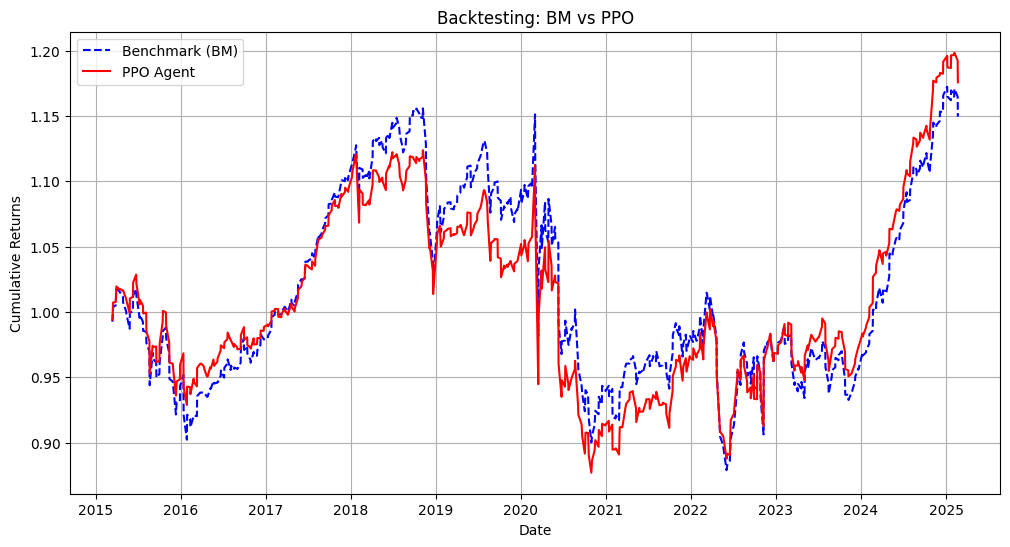

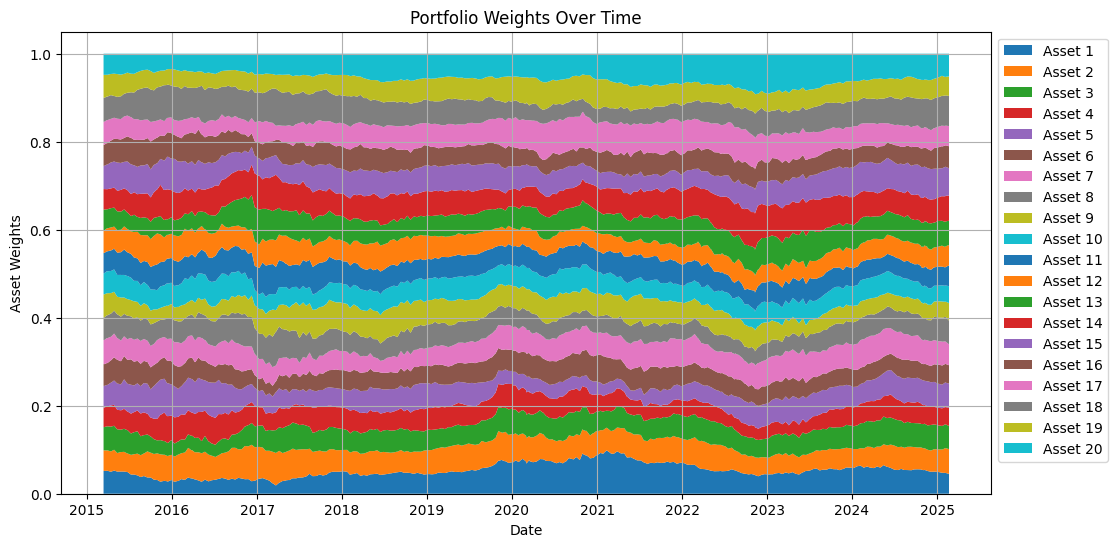

In [17]:
# 데이터 셋을 8 : 2 가 되도록 train : test 로 비율을 나누되, 전체 기간이 아닌 매 2주의 데이터셋 비율을 8 : 2로 나눠서 훈련.
# 이 훈련 결과를 토대로 그 다음 2주간의 업데이트에 반영하도록 수정. 그리고 이걸 반영해서 포트폴리오 비중 Plot (기간별) 파트를 수정
# 위 코드를 재수정

"""
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
# [수정됨] Log return 계산 (일별)
returns_df = np.log(data / data.shift(1)).dropna()"""

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# [수정됨] 데이터셋 분할: 매 2주(약 10 거래일) 단위로 분할, 각 블록을 80:20 (train:test)로 나눔
##############################################
block_size = 10      # 10일 단위 (2주)
train_size = int(block_size * 0.8)   # 8일
test_size = block_size - train_size  # 2일

# 블록별로 분할 (전체 daily returns_df)
blocks = []
for i in range(0, len(returns_df), block_size):
    block = returns_df.iloc[i:i+block_size]
    if len(block) < block_size:
        break
    blocks.append(block)

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # DataFrame, 일별 log returns
        self.n_assets = returns.shape[1]
        self.current_step = 0
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self.returns.iloc[self.current_step].values

    def step(self, action):
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns.iloc[self.current_step].values  # log return
        reward = np.dot(weights, current_return)
        self.current_step += 1
        done = self.current_step >= len(self.returns)
        next_state = self.returns.iloc[self.current_step].values if not done else np.zeros(self.n_assets)
        return next_state, reward, done, {}

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Dirichlet 분포 + GRU 사용
class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU 사용
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)
        gru_out, hidden = self.gru(x, hidden)  # GRU 호출
        gru_out = gru_out.squeeze(1)
        alpha = self.softplus(self.fc2(gru_out)) + 1e-6
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크: GRU 사용
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU 사용
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)
        gru_out, hidden = self.gru(x, hidden)
        gru_out = gru_out.squeeze(1)
        value = self.fc2(gru_out)
        return value, hidden

# 하이퍼파라미터
num_episodes = 50
gamma = 0.99
epsilon = 0.2
K_epochs = 10
entropy_coef = 0.01

input_dim = blocks[0].shape[1]
hidden_dim = 64
output_dim = blocks[0].shape[1]

# 모델 초기화 (초기 모델은 모든 블록에 대해 업데이트됨)
actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수 (동일)
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    actor.train()
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []
        state = env.reset()
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist, _ = actor(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        with torch.no_grad():
            baseline_values, _ = critic(states_tensor)
            baseline_values = baseline_values.squeeze(1)
        gae_lambda = 0.95
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        gae = 0
        advantages_list = []
        for t in reversed(range(len(rewards_tensor))):
            next_value = baseline_values[t + 1] if t < len(rewards_tensor) - 1 else torch.tensor(0.0, dtype=torch.float32)
            delta = rewards_tensor[t] + gamma * next_value - baseline_values[t]
            gae = delta + gamma * gae_lambda * gae
            advantages_list.insert(0, gae)
        advantages = torch.stack(advantages_list)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(K_epochs):
            values, _ = critic(states_tensor)
            values = values.squeeze(1)
            dist, _ = actor(states_tensor)
            new_log_probs = dist.log_prob(actions_tensor)
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy
            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

##############################################
# 6. 롤링 트레이닝 및 백테스팅 루프
##############################################
all_test_returns = []
all_test_weights = []
all_test_dates = []

# 전체 블록에 대해 순차적으로 진행: 각 블록은 10일 단위
for block in blocks:
    # 분할: train 8일, test 2일
    train_block = block.iloc[:train_size]
    test_block = block.iloc[train_size:train_size+test_size]

    # 훈련 환경 생성
    train_env = HistoricalPortfolioEnv(train_block)
    # 해당 블록의 train 데이터로 PPO 학습 (모델 업데이트: 이전 모델에서 시작)
    actor = train_ppo(num_episodes, train_env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

    # 테스트 환경 생성
    test_env = HistoricalPortfolioEnv(test_block)
    # 백테스팅: 해당 블록의 test 데이터로 평가 및 포트폴리오 비중 산출
    test_returns, test_weights = backtest(actor, test_block)
    all_test_returns.extend(test_returns)
    # test_weights는 (test_days, n_assets); get corresponding dates from test_block index
    all_test_weights.extend(test_weights)
    all_test_dates.extend(test_block.index.tolist())

# Convert lists to arrays/DataFrame
all_test_returns = np.array(all_test_returns)
all_test_weights = np.array(all_test_weights)
all_test_dates = pd.to_datetime(all_test_dates)

# 누적 수익률 계산: log returns의 누적합 후 exp
ppo_cumulative = np.exp(np.cumsum(all_test_returns))

# 벤치마크: test 데이터 전체를 연결하여 계산
test_benchmark = pd.concat([block.iloc[train_size:train_size+test_size] for block in blocks])
benchmark_daily = test_benchmark.dot(benchmark_weights).values
benchmark_cumulative = np.exp(np.cumsum(benchmark_daily))

##############################################
# 7. Backtesting Plot (누적 수익률) - 색상 고정
##############################################
plt.figure(figsize=(12,6))
plt.plot(all_test_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--", color="blue")
plt.plot(all_test_dates, ppo_cumulative, label="PPO Agent", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

##############################################
# 8. [수정됨] 포트폴리오 비중 Plot (기간별)
##############################################
plt.figure(figsize=(12,6))
# all_test_weights shape: (total_test_days, n_assets)
weights = all_test_weights.T  # 각 행: 자산, 각 열: test day
plt.stackplot(all_test_dates, weights, labels=[f"Asset {i+1}" for i in range(weights.shape[0])])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Date")
plt.ylabel("Asset Weights")
plt.title("Portfolio Weights Over Time")
plt.grid(True)
plt.show()

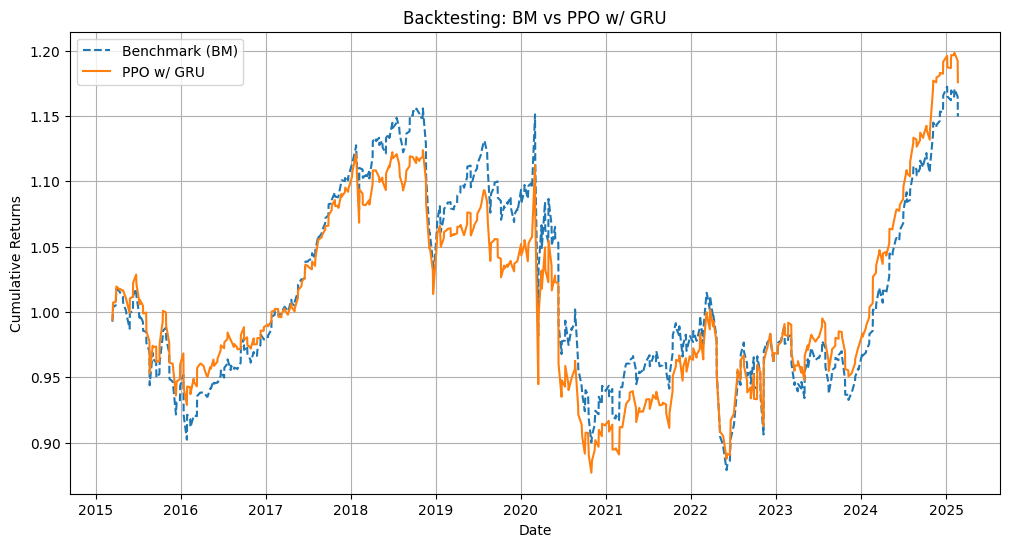

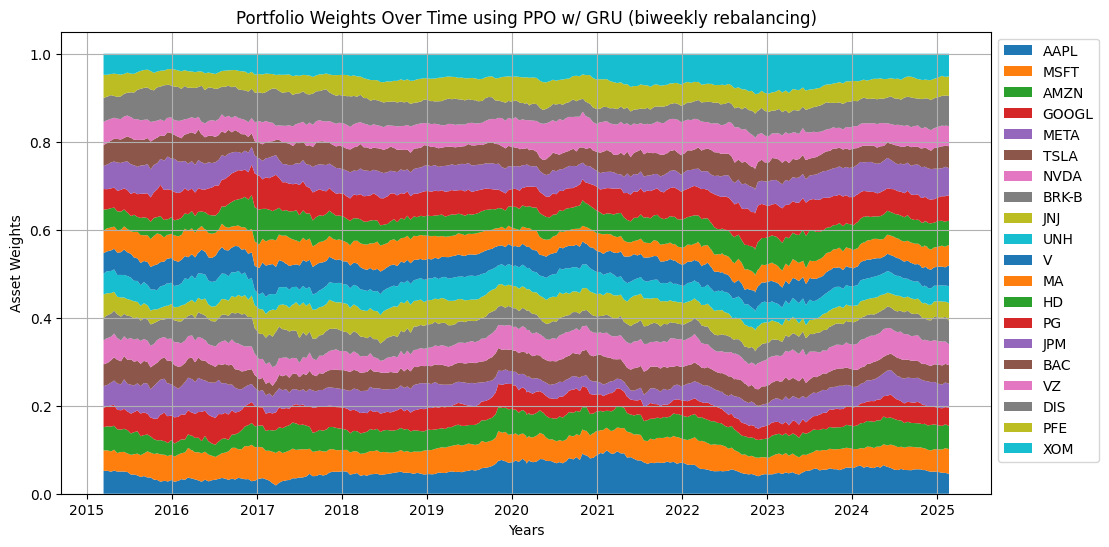

In [23]:
##############################################
# 7. Backtesting Plot (누적 수익률) - 색상 고정
##############################################
plt.figure(figsize=(12,6))
plt.plot(all_test_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(all_test_dates, ppo_cumulative, label="PPO w/ GRU")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: BM vs PPO w/ GRU")
plt.grid(True)
plt.show()

##############################################
# 8. [수정됨] 포트폴리오 비중 Plot (기간별)
##############################################
# [수정됨] 포트폴리오 비중 Plot (기간별) - 레전드에 실제 ticker명을 사용
plt.figure(figsize=(12,6))
# all_test_weights shape: (total_test_days, n_assets)
weights = all_test_weights.T  # 각 행: 자산, 각 열: test day
plt.stackplot(all_test_dates, weights, labels=tickers)  # ticker명 사용
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Years")
plt.ylabel("Asset Weights")
plt.title("Portfolio Weights Over Time using PPO w/ GRU (biweekly rebalancing)")
plt.grid(True)
plt.show()

<ipython-input-17-7a8288aec329>:205: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-17-7a8288aec329>:215: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
PPO Episode 0 | Reward: -0.0085 | Critic Loss: 0.0003
PPO Episode 1 | Reward: 0.0068 | Critic Loss: 0.0001
PPO Episode 2 | Reward: -0.0137 | Critic Loss: 0.0003
PPO Episode 3 | Reward: -0.0295 | Critic Loss: 0.0004
PPO Episode 4 | Reward: -0.0265 | Critic Loss: 0.0003
PPO Episode 5 | Reward: -0.0080 | Critic Loss: 0.0002
PPO Episode 6 | Reward: -0.0309 | Critic Loss: 0.0004
PPO Episode 7 | Reward: 0.0009 | Critic Loss: 0.0002
PPO Episode 8 | Reward: -0.0197 | Critic Loss: 0.0003
PPO Episode 9 | Reward: -0.0149 | Critic Loss: 0.0002
PPO Episode 10 | Reward: -0.0086 | Critic Loss: 0.0002
PPO Episode 11 | Reward: -0.0149 | Critic Loss: 0.0002
PPO Episode 12 | Reward: -0.0220 | Critic Loss: 0.0003
PPO Episode 13 | Reward: -0.0022 | Critic Loss: 0.0001
PPO Episode 14 | Reward: -0.0032 | Critic Loss: 0.0002
PPO Episode 15 | Reward: -0.0029 | Critic Loss: 0.0001
PPO Episode 16 | Reward: -0.0020 | Critic Loss: 0.0001
PPO Episode 17 | Reward: 0.0011 | Critic 

ValueError: x and y must have same first dimension, but have shapes (2500,) and (502,)

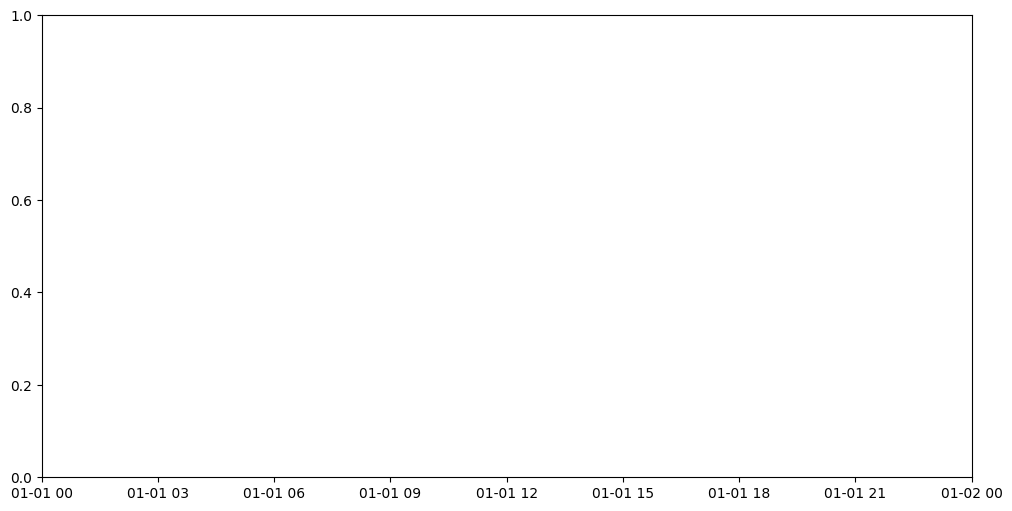

In [24]:
# 2주 중 2일 테스트 결과만 그리지말고 전체 결과를 plot하도록 수정

##############################################
# 6. 롤링 트레이닝 및 백테스팅 루프
##############################################
# [수정됨] 롤링 트레이닝 및 백테스팅 루프: 각 블록 i를 훈련, 블록 i+1을 테스트로 사용 (전체 블록 사용)
all_test_returns = []
all_test_weights = []
all_test_dates = []

for i in range(len(blocks) - 1):
    train_block = blocks[i]      # 블록 i 전체를 훈련 데이터로 사용
    test_block = blocks[i+1]     # 블록 i+1 전체를 테스트 데이터로 사용

    # 훈련 환경 생성 및 모델 업데이트
    train_env = HistoricalPortfolioEnv(train_block)
    actor = train_ppo(num_episodes, train_env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

    # 테스트 환경 생성: test_block 전체를 사용
    test_env = HistoricalPortfolioEnv(test_block)
    test_returns, test_weights = backtest(actor, test_block)

    all_test_returns.extend(test_returns)
    all_test_weights.extend(test_weights)
    all_test_dates.extend(test_block.index.tolist())

# Convert lists to arrays/DataFrame
all_test_returns = np.array(all_test_returns)
all_test_weights = np.array(all_test_weights)
all_test_dates = pd.to_datetime(all_test_dates)

# 누적 수익률 계산: log returns의 누적합 후 exp
ppo_cumulative = np.exp(np.cumsum(all_test_returns))

# 벤치마크: test 데이터 전체를 연결하여 계산
test_benchmark = pd.concat([block.iloc[train_size:train_size+test_size] for block in blocks])
benchmark_daily = test_benchmark.dot(benchmark_weights).values
benchmark_cumulative = np.exp(np.cumsum(benchmark_daily))

##############################################
# 7. Backtesting Plot (누적 수익률) - 색상 고정
##############################################
plt.figure(figsize=(12,6))
plt.plot(all_test_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(all_test_dates, ppo_cumulative, label="PPO w/ GRU")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: BM vs PPO w/ GRU")
plt.grid(True)
plt.show()

##############################################
# 8. [수정됨] 포트폴리오 비중 Plot (기간별)
##############################################
# [수정됨] 포트폴리오 비중 Plot (기간별) - 레전드에 실제 ticker명을 사용
plt.figure(figsize=(12,6))
# all_test_weights shape: (total_test_days, n_assets)
weights = all_test_weights.T  # 각 행: 자산, 각 열: test day
plt.stackplot(all_test_dates, weights, labels=tickers)  # ticker명 사용
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Years")
plt.ylabel("Asset Weights")
plt.title("Portfolio Weights Over Time using PPO w/ GRU (biweekly rebalancing)")
plt.grid(True)
plt.show()

In [ ]:


# [수정됨] benchmark_cumulative의 날짜 기준을 all_test_dates에 맞춤
benchmark_cumulative = benchmark_cumulative.loc[all_test_dates]
ppo_cumulative = ppo_cumulative.loc[all_test_dates]

plt.figure(figsize=(12,6))
plt.plot(all_test_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(all_test_dates, ppo_cumulative, label="PPO w/ GRU")
plt.legend()
plt.show()

# 누적 수익률 계산: log returns의 누적합 후 exp
ppo_cumulative = np.exp(np.cumsum(all_test_returns))

# 벤치마크: test 데이터 전체를 연결하여 계산
test_benchmark = pd.concat([block.iloc[train_size:train_size+test_size] for block in blocks])
benchmark_daily = test_benchmark.dot(benchmark_weights).values
benchmark_cumulative = np.exp(np.cumsum(benchmark_daily))

##############################################
# 7. Backtesting Plot (누적 수익률) - 색상 고정
##############################################
plt.figure(figsize=(12,6))
plt.plot(all_test_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(all_test_dates, ppo_cumulative, label="PPO w/ GRU")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: BM vs PPO w/ GRU")
plt.grid(True)
plt.show()

##############################################
# 8. [수정됨] 포트폴리오 비중 Plot (기간별)
##############################################
# [수정됨] 포트폴리오 비중 Plot (기간별) - 레전드에 실제 ticker명을 사용
plt.figure(figsize=(12,6))
# all_test_weights shape: (total_test_days, n_assets)
weights = all_test_weights.T  # 각 행: 자산, 각 열: test day
plt.stackplot(all_test_dates, weights, labels=tickers)  # ticker명 사용
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Years")
plt.ylabel("Asset Weights")
plt.title("Portfolio Weights Over Time using PPO w/ GRU (biweekly rebalancing)")
plt.grid(True)
plt.show()

[*********************100%***********************]  20 of 20 completed
<ipython-input-25-c49d7b17cdbe>:206: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-25-c49d7b17cdbe>:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
PPO Episode 0 | Reward: 0.0448 | Critic Loss: 0.0033
PPO Episode 1 | Reward: 0.0025 | Critic Loss: 0.0002
PPO Episode 2 | Reward: 0.0263 | Critic Loss: 0.0004
PPO Episode 3 | Reward: 0.0444 | Critic Loss: 0.0006
PPO Episode 4 | Reward: 0.0226 | Critic Loss: 0.0005
PPO Episode 5 | Reward: 0.0550 | Critic Loss: 0.0006
PPO Episode 6 | Reward: 0.0123 | Critic Loss: 0.0004
PPO Episode 7 | Reward: 0.0181 | Critic Loss: 0.0001
PPO Episode 8 | Reward: -0.0004 | Critic Loss: 0.0002
PPO Episode 9 | Reward: 0.0092 | Critic Loss: 0.0002
PPO Episode 10 | Reward: 0.0311 | Critic Loss: 0.0006
PPO Episode 11 | Reward: 0.0439 | Critic Loss: 0.0006
PPO Episode 12 | Reward: 0.0187 | Critic Loss: 0.0005
PPO Episode 13 | Reward: 0.0090 | Critic Loss: 0.0003
PPO Episode 14 | Reward: 0.0271 | Critic Loss: 0.0002
PPO Episode 15 | Reward: -0.0065 | Critic Loss: 0.0003
PPO Episode 16 | Reward: -0.0213 | Critic Loss: 0.0004
PPO Episode 17 | Reward: 0.0411 | Critic Loss: 0.0010

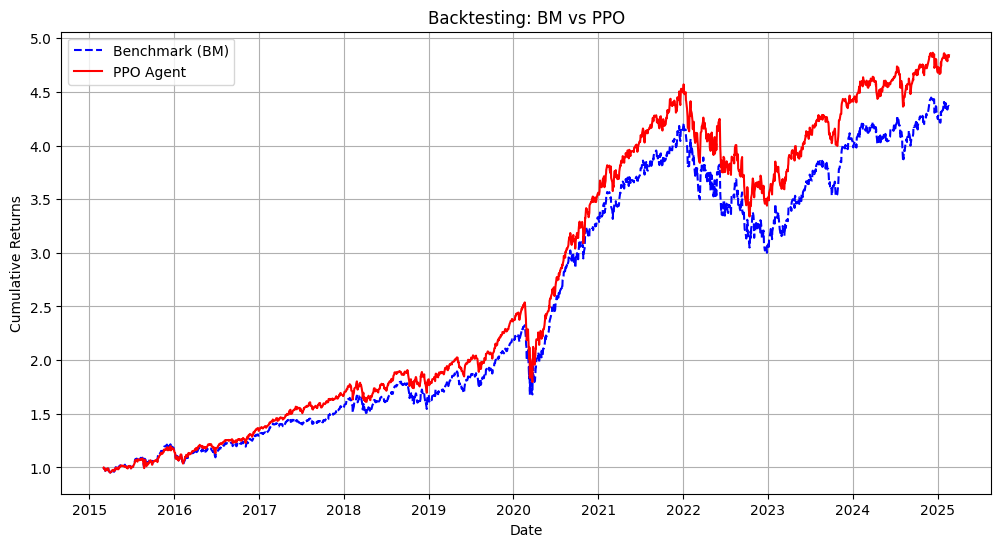

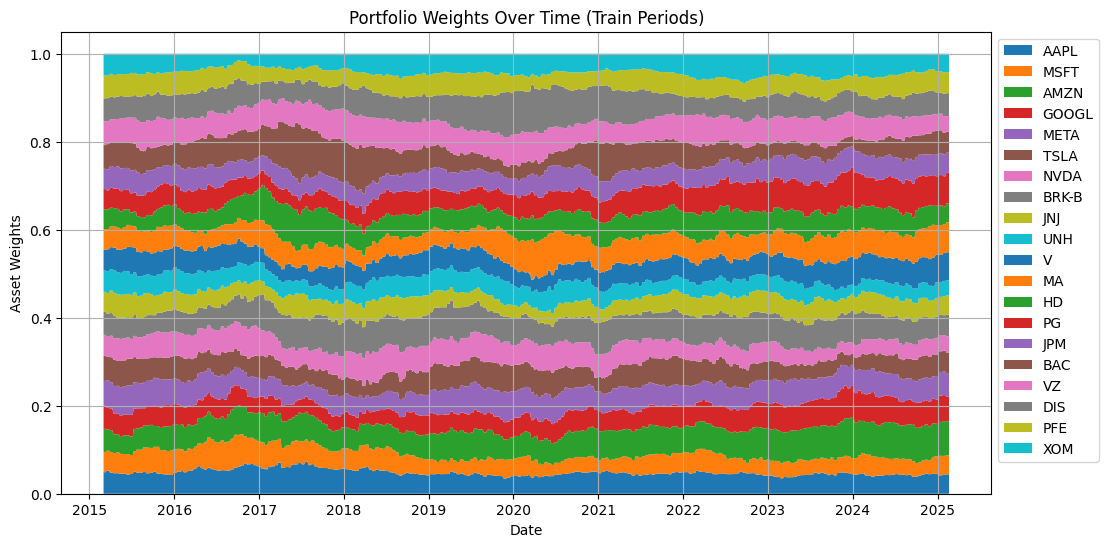

In [25]:
# 다시 전부 수정 사항을 반영한 코드
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
# [수정됨] Log return 계산 (일별)
returns_df = np.log(data / data.shift(1)).dropna()

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)

market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# [수정됨] 데이터셋 분할: 매 2주(10일) 단위로 분할, 각 블록을 80:20 (train:test)로 나눔
##############################################
block_size = 10      # 10일 단위 (약 2주)
train_size = int(block_size * 0.8)   # 8일
test_size = block_size - train_size  # 2일

# 전체 일별 log return 데이터를 10일 단위 블록으로 분할
blocks = []
for i in range(0, len(returns_df), block_size):
    block = returns_df.iloc[i:i+block_size]
    if len(block) < block_size:
        break
    blocks.append(block)

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # DataFrame, 일별 log returns
        self.n_assets = returns.shape[1]
        self.current_step = 0
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self.returns.iloc[self.current_step].values

    def step(self, action):
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns.iloc[self.current_step].values  # log return
        reward = np.dot(weights, current_return)
        self.current_step += 1
        done = self.current_step >= len(self.returns)
        next_state = self.returns.iloc[self.current_step].values if not done else np.zeros(self.n_assets)
        return next_state, reward, done, {}

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크: Dirichlet 분포 + GRU 사용
class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU 사용
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)  # (batch, 1, hidden_dim)
        gru_out, hidden = self.gru(x, hidden)  # GRU 호출
        gru_out = gru_out.squeeze(1)
        alpha = self.softplus(self.fc2(gru_out)) + 1e-6  # Dirichlet 파라미터 (양수 보장)
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크: GRU 사용
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU 사용
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)
        gru_out, hidden = self.gru(x, hidden)
        gru_out = gru_out.squeeze(1)
        value = self.fc2(gru_out)
        return value, hidden

##############################################
# 하이퍼파라미터 및 모델 초기화
##############################################
num_episodes = 50
gamma = 0.99
epsilon = 0.2
K_epochs = 10
entropy_coef = 0.01

input_dim = blocks[0].shape[1]
hidden_dim = 64
output_dim = blocks[0].shape[1]

# 초기 모델 (모든 블록에 대해 업데이트)
actor = Actor(input_dim, hidden_dim, output_dim)
critic = Critic(input_dim, hidden_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수 (동일)
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    actor.train()
    critic.train()

    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []
        state = env.reset()
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist, _ = actor(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())

            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state

        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)

        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)

        with torch.no_grad():
            baseline_values, _ = critic(states_tensor)
            baseline_values = baseline_values.squeeze(1)
        gae_lambda = 0.95
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        gae = 0
        advantages_list = []
        for t in reversed(range(len(rewards_tensor))):
            next_value = baseline_values[t + 1] if t < len(rewards_tensor) - 1 else torch.tensor(0.0, dtype=torch.float32)
            delta = rewards_tensor[t] + gamma * next_value - baseline_values[t]
            gae = delta + gamma * gae_lambda * gae
            advantages_list.insert(0, gae)
        advantages = torch.stack(advantages_list)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(K_epochs):
            values, _ = critic(states_tensor)
            values = values.squeeze(1)
            dist, _ = actor(states_tensor)
            new_log_probs = dist.log_prob(actions_tensor)
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy
            critic_loss = F.mse_loss(values, returns)

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")

    return actor

##############################################
# 6. 롤링 트레이닝 및 평가 루프 (매 2주 단위: 10일 → train:8일, test:2일)
##############################################
all_train_returns = []      # 각 블록의 train 데이터에 대한 PPO 포트폴리오 수익률 (평가용)
all_train_weights = []      # 각 블록의 train 데이터에 대한 포트폴리오 비중 (평가용)
all_train_dates = []        # 해당 블록의 날짜 (train 부분)

# 전체 블록 순회
for block in blocks:
    if len(block) < block_size:
        break
    # 분할: train 8일, test 2일
    train_block = block.iloc[:train_size]
    test_block = block.iloc[train_size:train_size+test_size]

    # 훈련 환경 생성 (train_block)
    train_env = HistoricalPortfolioEnv(train_block)
    # 해당 블록의 train 데이터로 PPO 학습 (이전 모델 상태에서 시작)
    actor = train_ppo(num_episodes, train_env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs)

    # 평가: train 환경에서 백테스팅하여 train 블록에 대한 결과 산출
    train_returns, train_weights = backtest(actor, train_block)
    all_train_returns.extend(train_returns)
    all_train_weights.extend(train_weights)
    all_train_dates.extend(train_block.index.tolist())

    # 테스트 환경 생성 (test_block) → 모델 업데이트에 반영 (여기서는 단순 평가로 진행)
    test_env = HistoricalPortfolioEnv(test_block)
    _ , _ = backtest(actor, test_block)
    # (테스트 결과를 모델 업데이트에 반영하는 구체적 방법은 별도 설계 필요)

# 누적 수익률 계산: train 데이터에 대해 적용한 PPO 수익률 (log returns 누적합의 exp)
ppo_cumulative = np.exp(np.cumsum(np.array(all_train_returns)))

# BM: 각 블록의 train 데이터에 대해 벤치마크 수익률 계산
train_bm_blocks = [block.iloc[:train_size] for block in blocks if len(block) >= block_size]
bm_returns_list = [train_block.dot(benchmark_weights).values for train_block in train_bm_blocks]
benchmark_train_returns = np.concatenate(bm_returns_list)
benchmark_cumulative = np.exp(np.cumsum(benchmark_train_returns))

all_train_dates = pd.to_datetime(all_train_dates)

##############################################
# 7. Backtesting Plot (누적 수익률) - 색상 고정
##############################################
plt.figure(figsize=(12,6))
plt.plot(all_train_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--", color="blue")
plt.plot(all_train_dates, ppo_cumulative, label="PPO Agent", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: BM vs PPO")
plt.grid(True)
plt.show()

##############################################
# 8. [수정됨] 포트폴리오 비중 Plot (기간별) - 실제 ticker명을 사용하여, train 블록의 비중을 순차적으로 Plot
##############################################
plt.figure(figsize=(12,6))
# all_train_weights shape: (total_train_days, n_assets)
weights = np.array(all_train_weights).T  # 각 행: asset, 각 열: train day
plt.stackplot(all_train_dates, weights, labels=tickers)  # ticker명을 레이블로 사용
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Date")
plt.ylabel("Asset Weights")
plt.title("Portfolio Weights Over Time (Train Periods)")
plt.grid(True)
plt.show()

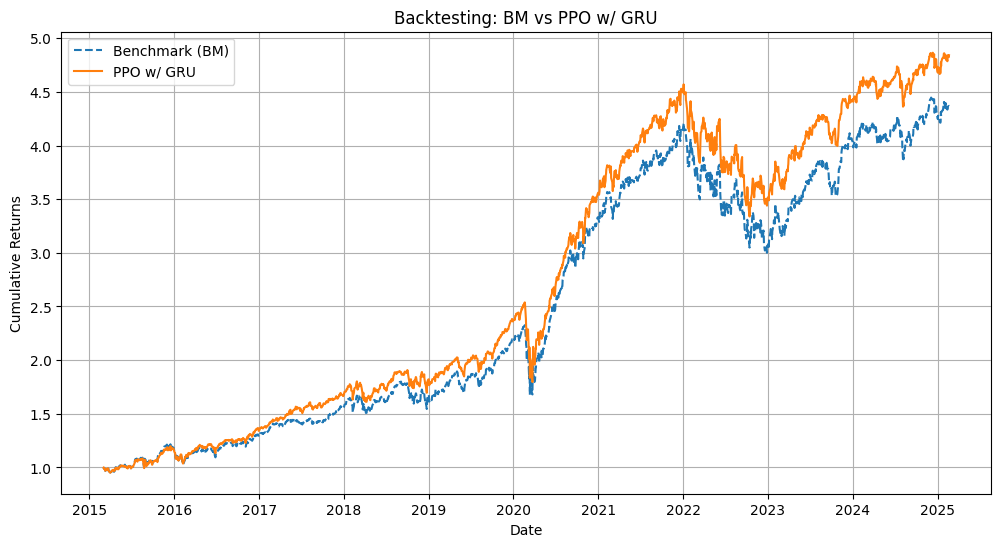

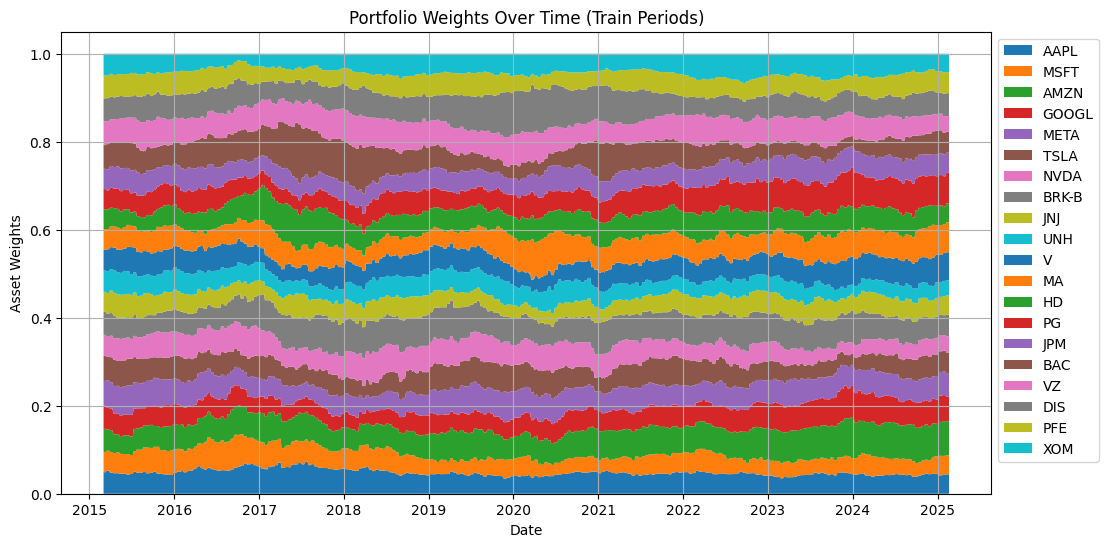

In [27]:
##############################################
# 7. Backtesting Plot (누적 수익률)
##############################################
plt.figure(figsize=(12,6))
plt.plot(all_train_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(all_train_dates, ppo_cumulative, label="PPO w/ GRU")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: BM vs PPO w/ GRU")
plt.grid(True)
plt.show()

##############################################
# 8. [수정됨] 포트폴리오 비중 Plot (기간별) - 실제 ticker명을 사용하여, train 블록의 비중을 순차적으로 Plot
##############################################
plt.figure(figsize=(12,6))
# all_train_weights shape: (total_train_days, n_assets)
weights = np.array(all_train_weights).T  # 각 행: asset, 각 열: train day
plt.stackplot(all_train_dates, weights, labels=tickers)  # ticker명을 레이블로 사용
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Date")
plt.ylabel("Asset Weights")
plt.title("Portfolio Weights Over Time (Train Periods)")
plt.grid(True)
plt.show()

<ipython-input-29-47c585e851d4>:235: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values, returns)
<ipython-input-29-47c585e851d4>:242: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
PPO Episode 0 | Reward: -0.0162 | Critic Loss: 0.0004
PPO Episode 1 | Reward: -0.0075 | Critic Loss: 0.0001
PPO Episode 2 | Reward: -0.0026 | Critic Loss: 0.0001
PPO Episode 3 | Reward: -0.0115 | Critic Loss: 0.0001
PPO Episode 4 | Reward: -0.0099 | Critic Loss: 0.0001
PPO Episode 5 | Reward: -0.0156 | Critic Loss: 0.0001
PPO Episode 6 | Reward: -0.0176 | Critic Loss: 0.0001
PPO Episode 7 | Reward: -0.0027 | Critic Loss: 0.0002
PPO Episode 8 | Reward: -0.0136 | Critic Loss: 0.0001
PPO Episode 9 | Reward: -0.0065 | Critic Loss: 0.0001
PPO Episode 10 | Reward: -0.0210 | Critic Loss: 0.0001
PPO Episode 11 | Reward: -0.0209 | Critic Loss: 0.0001
PPO Episode 12 | Reward: -0.0074 | Critic Loss: 0.0001
PPO Episode 13 | Reward: -0.0108 | Critic Loss: 0.0001
PPO Episode 14 | Reward: -0.0118 | Critic Loss: 0.0001
PPO Episode 15 | Reward: -0.0053 | Critic Loss: 0.0001
PPO Episode 16 | Reward: -0.0084 | Critic Loss: 0.0001
PPO Episode 17 | Reward: -0.0087 | Crit

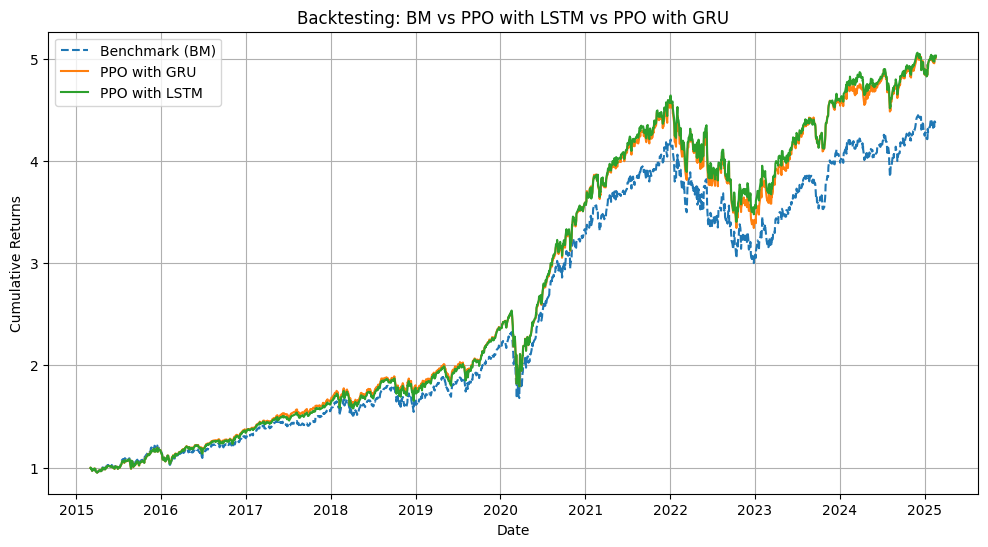

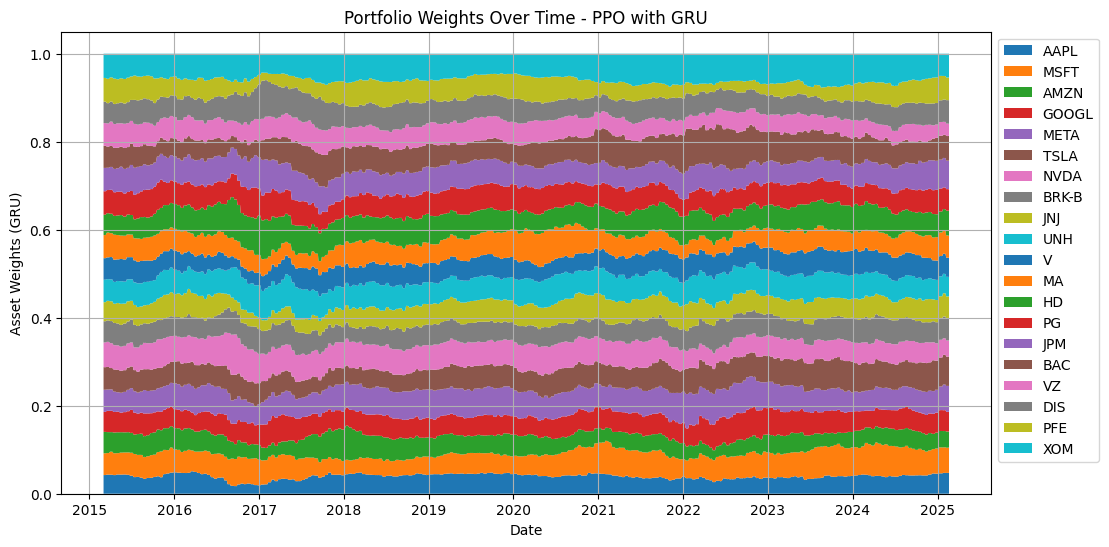

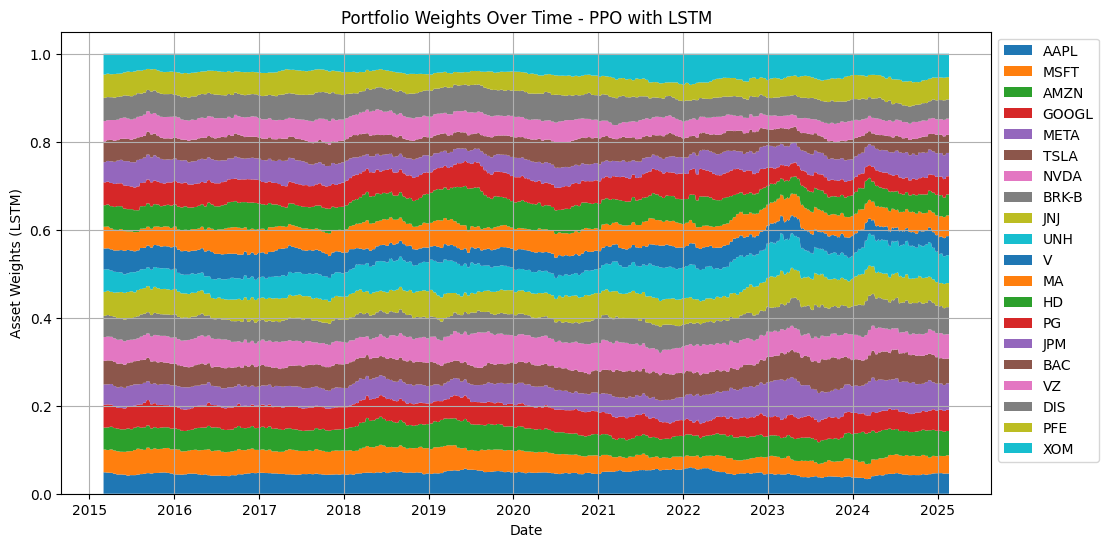

In [29]:
# 위 코드를 수정하여 BM vs PPO w/ GRU vs PPO w/ LSTM 을 비교(그래프)하는 코드
"""import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##############################################
# 1. 데이터 다운로드 및 전처리
##############################################
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BRK-B",
           "JNJ", "UNH", "V", "MA", "HD", "PG", "JPM", "BAC", "VZ", "DIS", "PFE", "XOM"]

end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
# [수정됨] Log return 계산 (일별)
returns_df = np.log(data / data.shift(1)).dropna()"""

##############################################
# 2. 벤치마크: 시가총액 비중 배분 계산
##############################################
market_caps = []
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        cap = info.get("marketCap", None)
        if cap is None:
            cap = 1e9
        market_caps.append(cap)
    except Exception as e:
        market_caps.append(1e9)
market_caps = np.array(market_caps)
benchmark_weights = market_caps / market_caps.sum()

##############################################
# [수정됨] 데이터셋 분할: 매 2주(10일) 단위로 분할, 각 블록을 80:20 (train:test)로 나눔
##############################################
block_size = 10      # 10일 단위 (약 2주)
train_size = int(block_size * 0.8)   # 8일
test_size = block_size - train_size  # 2일

blocks = []
for i in range(0, len(returns_df), block_size):
    block = returns_df.iloc[i:i+block_size]
    if len(block) < block_size:
        break
    blocks.append(block)

##############################################
# 3. 환경(Environment) 정의
##############################################
class HistoricalPortfolioEnv(gym.Env):
    def __init__(self, returns):
        super(HistoricalPortfolioEnv, self).__init__()
        self.returns = returns  # DataFrame, 일별 log returns
        self.n_assets = returns.shape[1]
        self.current_step = 0
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_assets,), dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self.returns.iloc[self.current_step].values

    def step(self, action):
        weights = action / (np.sum(action) + 1e-8)
        current_return = self.returns.iloc[self.current_step].values  # log return
        reward = np.dot(weights, current_return)
        self.current_step += 1
        done = self.current_step >= len(self.returns)
        next_state = self.returns.iloc[self.current_step].values if not done else np.zeros(self.n_assets)
        return next_state, reward, done, {}

##############################################
# 4. PPO 네트워크 정의
##############################################
# [수정됨] Actor 네트워크 - GRU 버전
class Actor_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor_GRU, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU 사용
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)
        gru_out, hidden = self.gru(x, hidden)
        gru_out = gru_out.squeeze(1)
        alpha = self.softplus(self.fc2(gru_out)) + 1e-6
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크 - GRU 버전
class Critic_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic_GRU, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU 사용
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)
        gru_out, hidden = self.gru(x, hidden)
        gru_out = gru_out.squeeze(1)
        value = self.fc2(gru_out)
        return value, hidden

# [수정됨] Actor 네트워크 - LSTM 버전
class Actor_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor_LSTM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)  # LSTM 사용
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.squeeze(1)
        alpha = self.softplus(self.fc2(lstm_out)) + 1e-6
        dist = torch.distributions.Dirichlet(alpha)
        return dist, hidden

# [수정됨] Critic 네트워크 - LSTM 버전
class Critic_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic_LSTM, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)  # LSTM 사용
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, hidden=None):
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(1)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.squeeze(1)
        value = self.fc2(lstm_out)
        return value, hidden

##############################################
# 하이퍼파라미터 및 초기화
##############################################
num_episodes = 50
gamma = 0.99
epsilon = 0.2
K_epochs = 10
entropy_coef = 0.01

input_dim = blocks[0].shape[1]
hidden_dim = 64
output_dim = blocks[0].shape[1]

# 모델 초기화: 각각 GRU와 LSTM 버전
actor_gru = Actor_GRU(input_dim, hidden_dim, output_dim)
critic_gru = Critic_GRU(input_dim, hidden_dim)
actor_lstm = Actor_LSTM(input_dim, hidden_dim, output_dim)
critic_lstm = Critic_LSTM(input_dim, hidden_dim)

actor_optimizer_gru = optim.Adam(actor_gru.parameters(), lr=1e-4)
critic_optimizer_gru = optim.Adam(critic_gru.parameters(), lr=1e-3)
actor_optimizer_lstm = optim.Adam(actor_lstm.parameters(), lr=1e-4)
critic_optimizer_lstm = optim.Adam(critic_lstm.parameters(), lr=1e-3)

##############################################
# 5. PPO 학습 함수 (동일, 모델 인스턴스에 따라 사용)
##############################################
def train_ppo(num_episodes, env, actor, critic, actor_optimizer, critic_optimizer, gamma, epsilon, K_epochs):
    actor.train()
    critic.train()
    for episode in range(num_episodes):
        states, actions, rewards, old_log_probs = [], [], [], []
        state = env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            dist, _ = actor(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            states.append(state)
            actions.append(action.detach())
            old_log_probs.append(log_prob.detach())
            next_state, reward, done, _ = env.step(action.detach().numpy())
            rewards.append(reward)
            state = next_state
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns, dtype=torch.float32)
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.stack(actions)
        old_log_probs_tensor = torch.stack(old_log_probs)
        with torch.no_grad():
            baseline_values, _ = critic(states_tensor)
            baseline_values = baseline_values.squeeze(1)
        gae_lambda = 0.95
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        gae = 0
        advantages_list = []
        for t in reversed(range(len(rewards_tensor))):
            next_value = baseline_values[t + 1] if t < len(rewards_tensor) - 1 else torch.tensor(0.0, dtype=torch.float32)
            delta = rewards_tensor[t] + gamma * next_value - baseline_values[t]
            gae = delta + gamma * gae_lambda * gae
            advantages_list.insert(0, gae)
        advantages = torch.stack(advantages_list)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        for _ in range(K_epochs):
            values, _ = critic(states_tensor)
            values = values.squeeze(1)
            dist, _ = actor(states_tensor)
            new_log_probs = dist.log_prob(actions_tensor)
            ratio = (new_log_probs - old_log_probs_tensor).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).mean() - entropy_coef * entropy
            critic_loss = F.mse_loss(values, returns)
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
        print(f"PPO Episode {episode} | Reward: {float(sum(rewards)):.4f} | Critic Loss: {critic_loss.item():.4f}")
    return actor

##############################################
# 6. 롤링 트레이닝 및 평가 루프 (매 2주 단위: 10일 → train:8일, test:2일)
##############################################
# 각 블록마다 train 데이터로 학습하고, backtest 결과(수익률, 비중)를 기록
all_train_returns_gru = []
all_train_weights_gru = []
all_train_returns_lstm = []
all_train_weights_lstm = []
all_train_dates = []

# 두 버전의 모델은 각각 독립적으로 업데이트
for block in blocks:
    if len(block) < block_size:
        break
    train_block = block.iloc[:train_size]
    test_block = block.iloc[train_size:train_size+test_size]
    # train 환경 생성
    train_env = HistoricalPortfolioEnv(train_block)
    # GRU 버전 학습
    actor_gru = train_ppo(num_episodes, train_env, actor_gru, critic_gru, actor_optimizer_gru, critic_optimizer_gru, gamma, epsilon, K_epochs)
    # LSTM 버전 학습
    actor_lstm = train_ppo(num_episodes, train_env, actor_lstm, critic_lstm, actor_optimizer_lstm, critic_optimizer_lstm, gamma, epsilon, K_epochs)
    # 평가: 각 모델의 train 결과 백테스트
    train_returns_gru, train_weights_gru = backtest(actor_gru, train_block)
    train_returns_lstm, train_weights_lstm = backtest(actor_lstm, train_block)
    all_train_returns_gru.extend(train_returns_gru)
    all_train_weights_gru.extend(train_weights_gru)
    all_train_returns_lstm.extend(train_returns_lstm)
    all_train_weights_lstm.extend(train_weights_lstm)
    all_train_dates.extend(train_block.index.tolist())
    # 테스트 블록은 단순 평가(모델 업데이트에 사용하지 않음)
    _ , _ = backtest(actor_gru, test_block)
    _ , _ = backtest(actor_lstm, test_block)

all_train_dates = pd.to_datetime(all_train_dates)

# 누적 수익률 계산: train 데이터 기반
ppo_cumulative_gru = np.exp(np.cumsum(np.array(all_train_returns_gru)))
ppo_cumulative_lstm = np.exp(np.cumsum(np.array(all_train_returns_lstm)))

# BM: 각 블록의 train 데이터에 대해 BM 수익률 계산
train_bm_blocks = [block.iloc[:train_size] for block in blocks if len(block) >= block_size]
bm_returns_list = [train_block.dot(benchmark_weights).values for train_block in train_bm_blocks]
benchmark_train_returns = np.concatenate(bm_returns_list)
benchmark_cumulative = np.exp(np.cumsum(benchmark_train_returns))

##############################################
# 7. Backtesting Plot (누적 수익률)
##############################################
plt.figure(figsize=(12,6))
plt.plot(all_train_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(all_train_dates, ppo_cumulative_gru, label="PPO with GRU")
plt.plot(all_train_dates, ppo_cumulative_lstm, label="PPO with LSTM")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: BM vs PPO with LSTM vs PPO with GRU")
plt.grid(True)
plt.show()

##############################################
# 8. [수정됨] 포트폴리오 비중 Plot (기간별) - 실제 ticker명을 사용
##############################################
# GRU 버전 비중
plt.figure(figsize=(12,6))
weights_gru = np.array(all_train_weights_gru).T  # (n_assets, total_train_days)
plt.stackplot(all_train_dates, weights_gru, labels=tickers)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Date")
plt.ylabel("Asset Weights (GRU)")
plt.title("Portfolio Weights Over Time - PPO with GRU")
plt.grid(True)
plt.show()

# LSTM 버전 비중
plt.figure(figsize=(12,6))
weights_lstm = np.array(all_train_weights_lstm).T  # (n_assets, total_train_days)
plt.stackplot(all_train_dates, weights_lstm, labels=tickers)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Date")
plt.ylabel("Asset Weights (LSTM)")
plt.title("Portfolio Weights Over Time - PPO with LSTM")
plt.grid(True)
plt.show()

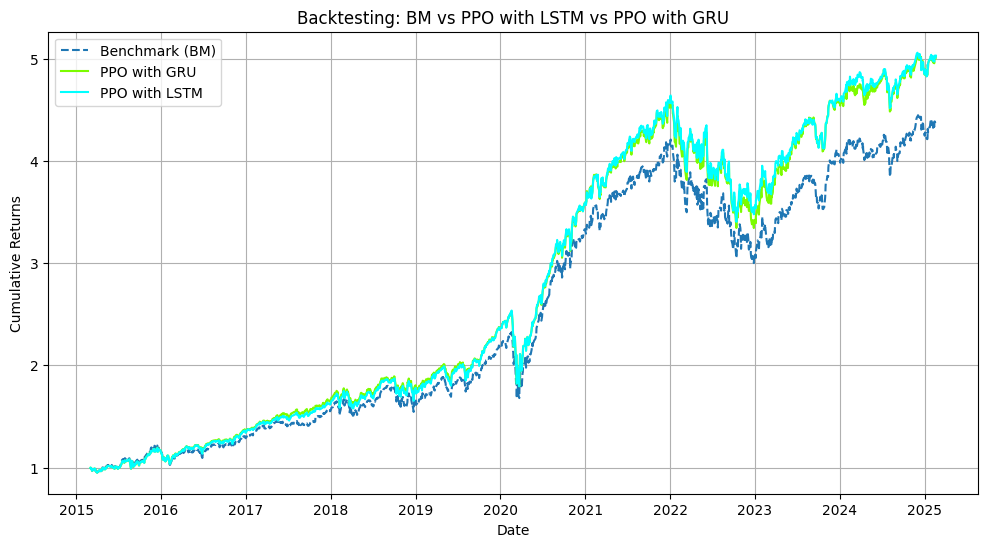

In [41]:
##############################################
# 7. Backtesting Plot (누적 수익률) - 색상 고정
##############################################
plt.figure(figsize=(12,6))
plt.plot(all_train_dates, benchmark_cumulative, label="Benchmark (BM)", linestyle="--")
plt.plot(all_train_dates, ppo_cumulative_gru, label="PPO with GRU", color="lawngreen")
plt.plot(all_train_dates, ppo_cumulative_lstm, label="PPO with LSTM", color="cyan")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Backtesting: BM vs PPO with LSTM vs PPO with GRU")
plt.grid(True)
plt.show()